In [1]:
!pip install gdown


In [2]:
import gdown

file_id = "1KXx1CW-BM3muxzCtmyhyv9xtWco_nDbL"
gdown.download(f"https://drive.google.com/uc?id={file_id}", output="dataset.zip", quiet=False)


Downloading...
From (original): https://drive.google.com/uc?id=1KXx1CW-BM3muxzCtmyhyv9xtWco_nDbL
From (redirected): https://drive.google.com/uc?id=1KXx1CW-BM3muxzCtmyhyv9xtWco_nDbL&confirm=t&uuid=3382495b-84ef-46ec-87c5-692490262cfb
To: /content/dataset.zip
100%|██████████| 2.38G/2.38G [00:20<00:00, 118MB/s]


'dataset.zip'

In [3]:
import zipfile

with zipfile.ZipFile("dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("dataset")


In [4]:
import os

print(os.listdir("dataset"))



['Comys_Hackathon5']


In [5]:

!pip install torch torchvision --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 123.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 97.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 45.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 105.0 MB/s eta 0:00:00


## 1.Library Imports

This code block imports all essential libraries and modules required for building a deep learning-based face recognition pipeline

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from PIL import Image
import random
import glob
from tqdm import tqdm
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, roc_auc_score
import pandas as pd
import csv
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import torchvision.transforms.functional as TF
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
import warnings
warnings.filterwarnings('ignore')

## 2.Configuration for Face Similarity Matching Model
This dictionary sets all essential hyperparameters and file paths for training a Face Similarity Matching Model, which determines if two face images represent the same person.

Training Settings: Epochs, batch size, learning rate, weight decay, and early stopping.

Loss Parameters: Margin, alpha, gamma for contrastive/focal loss behavior.

Scheduler: Warm-up epochs before applying learning rate schedule.

Paths: For dataset directories and various model checkpoints (best, optimal by metric).

Threshold Tuning: Range and steps for finding the best similarity/distance threshold.

Model Settings: Embedding size and dropout for regularization.

Data Augmentation: Optional mixup strategy with configurable strength.

In [ ]:
CONFIG = {
    'EPOCHS': 50,
    'BATCH_SIZE': 32,
    'LEARNING_RATE': 3e-4,
    'WEIGHT_DECAY': 1e-4,
    'PATIENCE': 8,
    'MARGIN': 1.2,
    'ALPHA': 0.2,
    'GAMMA': 2,
    'WARMUP_EPOCHS': 5,
    'TRAIN_DIR': '/content/dataset/Comys_Hackathon5/Task_B/train',
    'VAL_DIR': '/content/dataset/Comys_Hackathon5/Task_B/val',
    'MODEL_PATH': 'taskB_best_model.pth',
    'SIMILARITY_MODEL_PATH': 'taskB_best_similarity_model.pth',
    'DISTANCE_MODEL_PATH': 'taskB_best_distance_model.pth',
    'OPTIMAL_SIM_MODEL_PATH': 'taskB_optimal_similarity_model.pth',
    'OPTIMAL_DIST_MODEL_PATH': 'taskB_optimal_distance_model.pth',
    'CSV_LOG_PATH': 'taskB_metrics_log.csv',
    'THRESHOLD': 0.5,
    'THRESHOLD_SEARCH_RANGE': (0.1, 0.9),
    'THRESHOLD_SEARCH_STEPS': 20,
    'EMBEDDING_DIM': 256,
    'DROPOUT_RATE': 0.3,
    'USE_MIXUP': False,
    'MIXUP_ALPHA': 0.4
}

## 3.Data Augmentation & Noise Injection
NoiseLayer: Adds random Gaussian noise during training to make the model more robust to input variations.

train_transform: Applies resizing, flipping, color jitter, normalization — enhances data diversity for better generalization.

val_transform: Applies only resizing and normalization — ensures consistent evaluation.

In [ ]:
class NoiseLayer(nn.Module):
    def __init__(self, std=0.02):
        super().__init__()
        self.std = std

    def forward(self, x):
        if self.training:
            return x + torch.randn_like(x) * self.std
        return x

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


## 4.Face Similarity Pair Generator
The FacePairDataset class constructs a dataset of image pairs for training a face similarity model. It reads images from a structured directory where each identity has an "original" and a "distortion" subfolder. For each original image, it generates positive pairs by matching it with its own distorted versions, and negative pairs by pairing it with distortions from different identities. The ratio of negative to positive pairs is controlled via balance_ratio. It also applies specified transforms (like resizing or normalization) and handles missing or corrupt files gracefully. Finally, it assigns weights to each pair to help balance training.

** Key Features **
Generates both positive (same identity) and negative (different identity) image pairs.

Uses transformations on both images for preprocessing and augmentation.

Includes a class balancing strategy with configurable ratio.

Handles file errors with black image fallback.

Returns: (anchor_tensor, comparison_tensor, label) for training similarity networks.

In [ ]:
class FacePairDataset(Dataset):
    def __init__(self, root, transform, is_training=True, balance_ratio=1.5):
        self.transform = transform
        self.root = root
        self.is_training = is_training
        self.balance_ratio = balance_ratio
        self.entities = [d for d in os.listdir(root) if os.path.isdir(os.path.join(root, d))]
        self.data = []
        self.weights = []

        print(f"Found {len(self.entities)} entities")

        positive_count = 0
        negative_count = 0

        for entity in tqdm(self.entities, desc="Loading dataset"):
            entity_path = os.path.join(root, entity)
            distortion_path = os.path.join(entity_path, "distortion")

            if not os.path.exists(distortion_path):
                continue

            originals = glob.glob(os.path.join(entity_path, "*.jpg"))
            distorted = glob.glob(os.path.join(distortion_path, "*.jpg"))

            for orig in originals:
                same_dist = [d for d in distorted if
                           os.path.basename(d).startswith(os.path.splitext(os.path.basename(orig))[0])]
                for dimg in same_dist:
                    self.data.append((orig, dimg, 1))
                    positive_count += 1

                for _ in range(int(self.balance_ratio)):
                    neg_entity = random.choice([e for e in self.entities if e != entity])
                    neg_dist_path = os.path.join(root, neg_entity, "distortion")
                    if os.path.exists(neg_dist_path):
                        neg_dist = glob.glob(os.path.join(neg_dist_path, "*.jpg"))
                        if neg_dist:
                            self.data.append((orig, random.choice(neg_dist), 0))
                            negative_count += 1

        total_pos = positive_count
        total_neg = negative_count

        for _, _, label in self.data:
            if label == 1:
                self.weights.append(1.0 / total_pos)
            else:
                self.weights.append(1.0 / total_neg)

        print(f"Dataset created: {positive_count} positive, {negative_count} negative pairs")
        print(f"Class balance ratio: {negative_count/positive_count:.2f}")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        anchor_path, comp_path, label = self.data[idx]

        try:
            anchor = Image.open(anchor_path).convert("RGB")
            comp = Image.open(comp_path).convert("RGB")
        except Exception as e:
            print(f"Error loading images: {e}")
            anchor = Image.new('RGB', (224, 224), color='black')
            comp = Image.new('RGB', (224, 224), color='black')
            label = 0

        if self.transform:
            anchor = self.transform(anchor)
            comp = self.transform(comp)

        return anchor, comp, torch.tensor(label, dtype=torch.float32)

## 5.Dual-View Face Embedding Model with Attention
The FaceEmbedder is a custom neural network that generates robust face embeddings for similarity learning. It enhances standard CNN-based feature extraction by simulating distortions internally and using learnable attention to fuse clean and distorted representations.

**Key Components:**
ResNet-18 Backbone:
Pretrained feature extractor up to the second-last block (outputs 512 channels).

Feature Convolution (feature_conv):
Shallow transformation to project ResNet features into 256 channels.

Distortion Simulation (distortion_sim):
Applies a 1×1 conv to simulate internal distortions (learned variation).

Dual-View Fusion with Attention (attention_mlp):
Learns attention weights to fuse features from original and distorted branches.

Global Pooling + Embedding Head:
Converts fused features into a fixed-size embedding (e.g., 256-D) with normalization.

Weight Initialization:
Kaiming and normal initialization to stabilize training.

**Forward Pass Flow:**
Input image → ResNet features → 256-D projection.

Generate a second distorted-like version via conv simulation.

Fuse original and distorted features using attention.

Global average pooling → Dense + dropout → L2-normalized embedding.

In [ ]:
class FaceEmbedder(nn.Module):
    def __init__(self, embedding_dim=256, dropout_rate=0.3):
        super().__init__()

        # Base feature extractor
        backbone = models.resnet18(weights='DEFAULT')
        self.features = nn.Sequential(*list(backbone.children())[:-2])
        self.backbone_out_channels = 512

        # Shallow transform for original and distorted
        self.feature_conv = nn.Sequential(
            nn.Conv2d(self.backbone_out_channels, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout2d(dropout_rate)
        )

        # Internal distortion simulation (1x1 conv)
        self.distortion_sim = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )

        # Learnable attention for multi-view fusion
        self.attention_mlp = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(256 * 2, 64, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 2, kernel_size=1),
            nn.Softmax(dim=1)
        )

        # Global pooling and embedding head
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.embedding = nn.Sequential(
            nn.Linear(256, embedding_dim),
            nn.BatchNorm1d(embedding_dim),
            nn.Dropout(dropout_rate)
        )

        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                if m.weight is not None:
                    nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, (nn.BatchNorm2d, nn.BatchNorm1d)):
                if m.weight is not None:
                    nn.init.constant_(m.weight, 1)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                if m.weight is not None:
                    nn.init.normal_(m.weight, 0, 0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        feat = self.features(x)                # [B, 512, H, W]
        feat_orig = self.feature_conv(feat)    # [B, 256, H, W]

        # Simulate distortion
        feat_aug = self.distortion_sim(feat_orig)

        # Concatenate and compute attention weights
        fusion_input = torch.cat([feat_orig.unsqueeze(1), feat_aug.unsqueeze(1)], dim=1)  # [B, 2, 256, H, W]
        fusion_input = fusion_input.view(x.size(0), 512, feat_orig.size(2), feat_orig.size(3))  # [B, 512, H, W]

        att = self.attention_mlp(fusion_input)  # [B, 2, 1, 1]
        alpha = att[:, 0:1]                     # attention for orig
        beta = att[:, 1:2]                      # attention for aug

        fused_feat = alpha * feat_orig + beta * feat_aug

        pooled = self.global_pool(fused_feat).flatten(1)
        embedding = self.embedding(pooled)
        return F.normalize(embedding, p=2, dim=1)


## 6.Custom Loss Functions for Face Similarity Learning
This block defines three custom loss functions designed to improve training for face similarity models by combining distance-based and confidence-aware strategies.

1. FocalBCE – Focal Binary Cross-Entropy Loss
Adds a focusing term to standard BCE loss.

Helps the model focus more on hard or misclassified examples.

Controlled by alpha (scaling) and gamma (focusing).

2. TripletMarginLoss – Distance-Based Ranking Loss
Enforces that the positive pair is closer than the negative pair by a margin.

Computes loss: max(0, d(anchor, pos) - d(anchor, neg) + margin).

Encourages embedding separation between identities.

 3. HybridLoss – Contrastive + Cosine Similarity Fusion
Combines:

Contrastive Loss: Pulls similar embeddings together, pushes apart dissimilar ones.

Cosine Similarity Loss: Enforces directional alignment between embeddings.

Weighted by alpha to balance both components.

In [ ]:
class FocalBCE(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        ce_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1-pt)**self.gamma * ce_loss
        return focal_loss.mean()

class TripletMarginLoss(nn.Module):
    def __init__(self, margin=1.0):
        super().__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        distance_positive = F.pairwise_distance(anchor, positive)
        distance_negative = F.pairwise_distance(anchor, negative)
        losses = F.relu(distance_positive - distance_negative + self.margin)
        return losses.mean()

class HybridLoss(nn.Module):
    def __init__(self, margin=1.0, alpha=0.7):
        super().__init__()
        self.margin = margin
        self.alpha = alpha

    def forward(self, emb1, emb2, labels):
        distances = F.pairwise_distance(emb1, emb2)
        contrastive = torch.mean(
            labels * distances**2 +
            (1 - labels) * F.relu(self.margin - distances)**2
        )

        cos_sim = F.cosine_similarity(emb1, emb2)
        cosine_loss = torch.mean(
            labels * (1 - cos_sim) +
            (1 - labels) * F.relu(cos_sim + 0.1)
        )

        return self.alpha * contrastive + (1 - self.alpha) * cosine_loss

## 7.Mixup for Face Pair Training
This code defines mixup augmentation functions for use in training a face similarity model on paired inputs

In [ ]:
def mixup_pairs(x1, x2, y, alpha=1.0):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x1.size(0)
    index = torch.randperm(batch_size).to(x1.device)

    mixed_x1 = lam * x1 + (1 - lam) * x1[index]
    mixed_x2 = lam * x2 + (1 - lam) * x2[index]
    y_a, y_b = y, y[index]

    return mixed_x1, mixed_x2, y_a, y_b, lam

def mixup_loss(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

## 8. Threshold Optimization for Face Matching
This function searches for the best similarity and distance thresholds by evaluating model predictions over a range and selecting the one that maximizes a chosen metric (e.g., F1 score) on the validation set.

In [ ]:
@torch.no_grad()
def optimize_thresholds(model, dataloader, device, threshold_range=(0.1, 0.9), steps=50, metric='f1'):
    model.eval()
    all_embeddings1, all_embeddings2, labels = [], [], []

    with torch.no_grad():
        for batch in dataloader:
            anchor, comp, batch_labels = [x.to(device) for x in batch]
            emb1 = model(anchor)
            emb2 = model(comp)
            all_embeddings1.append(emb1)
            all_embeddings2.append(emb2)
            labels.append(batch_labels)

    all_embeddings1 = torch.cat(all_embeddings1)
    all_embeddings2 = torch.cat(all_embeddings2)
    labels = torch.cat(labels).cpu().numpy()

    similarities = F.cosine_similarity(all_embeddings1, all_embeddings2).cpu().numpy()
    distances = F.pairwise_distance(all_embeddings1, all_embeddings2).cpu().numpy()

    thresholds = np.linspace(threshold_range[0], threshold_range[1], steps)

    best_sim_threshold = threshold_range[0]
    best_sim_score = 0
    best_sim_metrics = {}

    best_dist_threshold = threshold_range[0]
    best_dist_score = 0
    best_dist_metrics = {}

    sim_threshold_results = []
    dist_threshold_results = []

    print("Optimizing similarity threshold...")
    for threshold in tqdm(thresholds, desc="Similarity thresholds"):
        sim_preds = (similarities > threshold).astype(int)

        acc = accuracy_score(labels, sim_preds)
        prec, rec, f1, _ = precision_recall_fscore_support(labels, sim_preds, average='binary', zero_division=0)
        _, _, macro_f1, _ = precision_recall_fscore_support(labels, sim_preds, average='macro', zero_division=0)

        metrics = {
            'threshold': threshold,
            'accuracy': acc,
            'precision': prec,
            'recall': rec,
            'f1': f1,
            'macro_f1': macro_f1
        }
        sim_threshold_results.append(metrics)

        if metric == 'f1':
            score = f1
        elif metric == 'macro_f1':
            score = macro_f1
        elif metric == 'accuracy':
            score = acc
        else:
            score = f1

        if score > best_sim_score:
            best_sim_score = score
            best_sim_threshold = threshold
            best_sim_metrics = metrics.copy()

    print("Optimizing distance threshold...")
    for threshold in tqdm(thresholds, desc="Distance thresholds"):
        dist_preds = (distances < threshold).astype(int)

        acc = accuracy_score(labels, dist_preds)
        prec, rec, f1, _ = precision_recall_fscore_support(labels, dist_preds, average='binary', zero_division=0)
        _, _, macro_f1, _ = precision_recall_fscore_support(labels, dist_preds, average='macro', zero_division=0)

        metrics = {
            'threshold': threshold,
            'accuracy': acc,
            'precision': prec,
            'recall': rec,
            'f1': f1,
            'macro_f1': macro_f1
        }
        dist_threshold_results.append(metrics)

        if metric == 'f1':
            score = f1
        elif metric == 'macro_f1':
            score = macro_f1
        elif metric == 'accuracy':
            score = acc
        else:
            score = f1

        if score > best_dist_score:
            best_dist_score = score
            best_dist_threshold = threshold
            best_dist_metrics = metrics.copy()

    return {
        'similarity': {
            'optimal_threshold': best_sim_threshold,
            'best_metrics': best_sim_metrics,
            'all_results': sim_threshold_results
        },
        'distance': {
            'optimal_threshold': best_dist_threshold,
            'best_metrics': best_dist_metrics,
            'all_results': dist_threshold_results
        }
    }


## 9.valuation Function for Face Similarity Model
This function evaluates a trained model by comparing embeddings of face pairs using both cosine similarity and Euclidean distance, then computes metrics like accuracy, precision, recall, F1, macro-F1, and ROC-AUC based on given thresholds.

In [ ]:
@torch.no_grad()
def evaluate_model(model, dataloader, device, sim_threshold=0.5, dist_threshold=0.5):
    model.eval()
    all_embeddings1, all_embeddings2, labels = [], [], []

    with torch.no_grad():
        for batch in dataloader:
            anchor, comp, batch_labels = [x.to(device) for x in batch]

            emb1 = model(anchor)
            emb2 = model(comp)

            all_embeddings1.append(emb1)
            all_embeddings2.append(emb2)
            labels.append(batch_labels)

    all_embeddings1 = torch.cat(all_embeddings1)
    all_embeddings2 = torch.cat(all_embeddings2)
    labels = torch.cat(labels)

    similarities = F.cosine_similarity(all_embeddings1, all_embeddings2)
    distances = F.pairwise_distance(all_embeddings1, all_embeddings2)

    sim_preds = (similarities > sim_threshold).long()
    dist_preds = (distances < dist_threshold).long()

    dist_acc = accuracy_score(labels.cpu(), dist_preds.cpu())
    dist_prec, dist_rec, dist_f1, _ = precision_recall_fscore_support(
        labels.cpu(), dist_preds.cpu(), average='binary', zero_division=0
    )
    _, _, dist_macro_f1, _ = precision_recall_fscore_support(
        labels.cpu(), dist_preds.cpu(), average='macro', zero_division=0
    )

    sim_acc = accuracy_score(labels.cpu(), sim_preds.cpu())
    sim_prec, sim_rec, sim_f1, _ = precision_recall_fscore_support(
        labels.cpu(), sim_preds.cpu(), average='binary', zero_division=0
    )
    _, _, sim_macro_f1, _ = precision_recall_fscore_support(
        labels.cpu(), sim_preds.cpu(), average='macro', zero_division=0
    )

    try:
        dist_auc = roc_auc_score(labels.cpu(), -distances.cpu())
        sim_auc = roc_auc_score(labels.cpu(), similarities.cpu())
    except ValueError:
        dist_auc = 0.5
        sim_auc = 0.5

    return {
        'dist_acc': dist_acc, 'dist_prec': dist_prec, 'dist_rec': dist_rec,
        'dist_f1': dist_f1, 'dist_macro_f1': dist_macro_f1, 'dist_auc': dist_auc,
        'sim_acc': sim_acc, 'sim_prec': sim_prec, 'sim_rec': sim_rec,
        'sim_f1': sim_f1, 'sim_macro_f1': sim_macro_f1, 'sim_auc': sim_auc,
        'sim_threshold': sim_threshold, 'dist_threshold': dist_threshold
    }

## 10.Full Training Pipeline for Face Similarity Model
This function handles the entire training loop for a face similarity model using a hybrid loss and cosine annealing learning rate scheduler. It evaluates the model after every epoch using both similarity and distance thresholds and keeps track of the best-performing checkpoints.

Key Features:
Loss: Uses HybridLoss combining contrastive and cosine losses.

Scheduler: Cosine annealing with warm restarts for smooth learning rate decay.

Evaluation: Computes validation metrics (F1, accuracy, AUC) using both cosine similarity and Euclidean distance.

Model Checkpointing: Saves the best models based on:

Similarity F1 (SIMILARITY_MODEL_PATH)

Distance F1 (DISTANCE_MODEL_PATH)

Overall best (MODEL_PATH)

Logging: Saves training logs to CSV and optionally checkpoints every 5 epochs.

Early Stopping: Stops training if no improvement in loss or F1 score for a specified number of epochs.

In [ ]:
def train_model(model, train_loader, val_loader, optimizer, device, config):
    criterion = HybridLoss(margin=config['MARGIN'])
    scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)

    best_sim_f1 = 0
    best_sim_macro_f1 = 0
    best_dist_f1 = 0
    best_dist_macro_f1 = 0
    best_val_loss = float('inf')

    early_stop_counter = 0
    metrics_history = []

    os.makedirs("checkpoints", exist_ok=True)

    for epoch in range(1, config['EPOCHS'] + 1):
        model.train()
        total_loss = 0
        num_batches = 0

        print(f"\n{'='*50}")
        print(f"Epoch {epoch}/{config['EPOCHS']}")
        print(f"{'='*50}")

        progress_bar = tqdm(train_loader, desc="Training")

        for batch_idx, (anchor, comp, label) in enumerate(progress_bar):
            anchor, comp, label = anchor.to(device), comp.to(device), label.to(device)

            emb1, emb2 = model(anchor), model(comp)
            loss = criterion(emb1, emb2, label)

            optimizer.zero_grad()
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()
            scheduler.step(epoch + batch_idx / len(train_loader))

            total_loss += loss.item()
            num_batches += 1

            if batch_idx % 50 == 0:
                torch.cuda.empty_cache()

            progress_bar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Avg Loss': f'{total_loss/num_batches:.4f}',
                'LR': f'{optimizer.param_groups[0]["lr"]:.2e}'
            })

        torch.cuda.empty_cache()

        avg_train_loss = total_loss / len(train_loader)

        val_metrics = evaluate_model(model, val_loader, device, config['THRESHOLD'])

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for anchor, comp, label in val_loader:
                anchor, comp, label = anchor.to(device), comp.to(device), label.to(device)
                emb1, emb2 = model(anchor), model(comp)
                loss = criterion(emb1, emb2, label)
                val_loss += loss.item()
        avg_val_loss = val_loss / len(val_loader)

        torch.cuda.empty_cache()

        print(f"\nEpoch {epoch} Results:")
        print(f"Train Loss: {avg_train_loss:.4f}")
        print(f"Validation Loss: {avg_val_loss:.4f}")
        print(f"Distance-based - Acc: {val_metrics['dist_acc']:.4f}, F1: {val_metrics['dist_f1']:.4f}, Macro F1: {val_metrics['dist_macro_f1']:.4f}, AUC: {val_metrics['dist_auc']:.4f}")
        print(f"Similarity-based - Acc: {val_metrics['sim_acc']:.4f}, F1: {val_metrics['sim_f1']:.4f}, Macro F1: {val_metrics['sim_macro_f1']:.4f}, AUC: {val_metrics['sim_auc']:.4f}")

        metrics = {
            'epoch': epoch,
            'train_loss': avg_train_loss,
            'val_loss': avg_val_loss,
            'learning_rate': optimizer.param_groups[0]['lr'],
            **{f'val_{k}': v for k, v in val_metrics.items()}
        }
        metrics_history.append(metrics)

        df = pd.DataFrame([metrics])
        if epoch == 1:
            df.to_csv(config['CSV_LOG_PATH'], index=False)
        else:
            df.to_csv(config['CSV_LOG_PATH'], mode='a', header=False, index=False)

        sim_improved = False
        dist_improved = False
        val_loss_improved = False

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            val_loss_improved = True

        if val_metrics['sim_f1'] > best_sim_f1:
            best_sim_f1 = val_metrics['sim_f1']
            sim_improved = True

            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_sim_f1': best_sim_f1,
                'best_sim_macro_f1': val_metrics['sim_macro_f1'],
                'metrics': val_metrics,
                'config': config,
                'model_type': 'similarity'
            }, config['SIMILARITY_MODEL_PATH'])

            print(f"New best similarity model saved with F1: {best_sim_f1:.4f}, Macro F1: {val_metrics['sim_macro_f1']:.4f}")

        if val_metrics['dist_f1'] > best_dist_f1:
            best_dist_f1 = val_metrics['dist_f1']
            dist_improved = True

            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_dist_f1': best_dist_f1,
                'best_dist_macro_f1': val_metrics['dist_macro_f1'],
                'metrics': val_metrics,
                'config': config,
                'model_type': 'distance'
            }, config['DISTANCE_MODEL_PATH'])

            print(f"New best distance model saved with F1: {best_dist_f1:.4f}, Macro F1: {val_metrics['dist_macro_f1']:.4f}")

        if val_metrics['sim_macro_f1'] > best_sim_macro_f1:
            best_sim_macro_f1 = val_metrics['sim_macro_f1']

        if val_metrics['dist_macro_f1'] > best_dist_macro_f1:
            best_dist_macro_f1 = val_metrics['dist_macro_f1']

        current_best_f1 = max(val_metrics['sim_f1'], val_metrics['dist_f1'])
        overall_best_f1 = max(best_sim_f1, best_dist_f1)

        if current_best_f1 >= overall_best_f1:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_sim_f1': best_sim_f1,
                'best_dist_f1': best_dist_f1,
                'best_sim_macro_f1': best_sim_macro_f1,
                'best_dist_macro_f1': best_dist_macro_f1,
                'metrics': val_metrics,
                'config': config,
                'model_type': 'overall_best'
            }, config['MODEL_PATH'])

        if sim_improved or dist_improved or val_loss_improved:
            early_stop_counter = 0
        else:
            early_stop_counter += 1

            if epoch % 5 == 0:
                ckpt_path = f"checkpoints/epoch_{epoch:03d}_simF1_{val_metrics['sim_f1']:.4f}_distF1_{val_metrics['dist_f1']:.4f}_valLoss_{avg_val_loss:.4f}.pth"
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'metrics': val_metrics,
                    'config': config
                }, ckpt_path)

            if early_stop_counter >= config['PATIENCE']:
                print(f"Early stopping triggered after {config['PATIENCE']} epochs without improvement in F1 scores or validation loss")
                print(f"Best validation loss: {best_val_loss:.4f}")
                break

    final_path = config['MODEL_PATH'].replace('.pth', '_final.pth')
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'final_metrics': val_metrics,
        'best_sim_f1': best_sim_f1,
        'best_dist_f1': best_dist_f1,
        'best_sim_macro_f1': best_sim_macro_f1,
        'best_dist_macro_f1': best_dist_macro_f1,
        'best_val_loss': best_val_loss,
        'config': config
    }, final_path)

    print(f"\nTraining completed!")
    print(f"Best Validation Loss: {best_val_loss:.4f}")
    print(f"Best Similarity F1: {best_sim_f1:.4f}, Macro F1: {best_sim_macro_f1:.4f}")
    print(f"Best Distance F1: {best_dist_f1:.4f}, Macro F1: {best_dist_macro_f1:.4f}")

    return metrics_history


## 11.Training Launcher for Face Similarity System
The main() function sets up and launches the entire training pipeline for the face similarity model, handling initialization, data loading, model creation, and training execution.



In [ ]:
def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    torch.manual_seed(42)
    np.random.seed(42)
    random.seed(42)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(42)

    model = FaceEmbedder(
        embedding_dim=CONFIG['EMBEDDING_DIM'],
        dropout_rate=CONFIG['DROPOUT_RATE']
    ).to(device)

    print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

    print("Creating datasets...")
    train_dataset = FacePairDataset(
        CONFIG['TRAIN_DIR'], train_transform, is_training=True
    )
    val_dataset = FacePairDataset(
        CONFIG['VAL_DIR'], val_transform, is_training=False
    )

    sampler = WeightedRandomSampler(
        weights=train_dataset.weights,
        num_samples=len(train_dataset),
        replacement=True
    )

    train_loader = DataLoader(
        train_dataset,
        batch_size=CONFIG['BATCH_SIZE'],
        sampler=sampler,
        num_workers=2,
        pin_memory=False
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=CONFIG['BATCH_SIZE'],
        shuffle=False,
        num_workers=2,
        pin_memory=False
    )

    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=CONFIG['LEARNING_RATE'],
        weight_decay=CONFIG['WEIGHT_DECAY']
    )

    print("Starting training...")
    metrics_history = train_model(
        model, train_loader, val_loader, optimizer, device, CONFIG
    )

    print("Training completed successfully!")
    print(f"Metrics saved to: {CONFIG['CSV_LOG_PATH']}")
    print(f"Best overall model saved to: {CONFIG['MODEL_PATH']}")
    print(f"Best similarity model saved to: {CONFIG['SIMILARITY_MODEL_PATH']}")
    print(f"Best distance model saved to: {CONFIG['DISTANCE_MODEL_PATH']}")

if __name__ == "__main__":
    main()

Using device: cuda


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 237MB/s]


Model parameters: 12,522,498
Creating datasets...
Found 877 entities


Loading dataset: 100%|██████████| 877/877 [00:01<00:00, 808.13it/s] 


Dataset created: 13482 positive, 1926 negative pairs
Class balance ratio: 0.14
Found 250 entities


Loading dataset: 100%|██████████| 250/250 [00:00<00:00, 3396.75it/s]


Dataset created: 2954 positive, 422 negative pairs
Class balance ratio: 0.14
Starting training...

Epoch 1/50


Training: 100%|██████████| 482/482 [03:21<00:00,  2.39it/s, Loss=0.6033, Avg Loss=0.5075, LR=2.71e-04]



Epoch 1 Results:
Train Loss: 0.5075
Validation Loss: 0.1624
Distance-based - Acc: 0.8400, F1: 0.9055, Macro F1: 0.6921, AUC: 0.8572
Similarity-based - Acc: 0.8937, F1: 0.9408, Macro F1: 0.7084, AUC: 0.8572
New best similarity model saved with F1: 0.9408, Macro F1: 0.7084
New best distance model saved with F1: 0.9055, Macro F1: 0.6921

Epoch 2/50


Training: 100%|██████████| 482/482 [03:15<00:00,  2.47it/s, Loss=0.5659, Avg Loss=0.4188, LR=2.38e-04]



Epoch 2 Results:
Train Loss: 0.4188
Validation Loss: 0.1089
Distance-based - Acc: 0.8937, F1: 0.9378, Macro F1: 0.7856, AUC: 0.9100
Similarity-based - Acc: 0.9259, F1: 0.9589, Macro F1: 0.7929, AUC: 0.9100
New best similarity model saved with F1: 0.9589, Macro F1: 0.7929
New best distance model saved with F1: 0.9378, Macro F1: 0.7856

Epoch 3/50


Training: 100%|██████████| 482/482 [03:14<00:00,  2.47it/s, Loss=0.4536, Avg Loss=0.3980, LR=1.96e-04]



Epoch 3 Results:
Train Loss: 0.3980
Validation Loss: 0.1135
Distance-based - Acc: 0.8830, F1: 0.9319, Macro F1: 0.7591, AUC: 0.8938
Similarity-based - Acc: 0.9194, F1: 0.9555, Macro F1: 0.7639, AUC: 0.8938

Epoch 4/50


Training: 100%|██████████| 482/482 [03:18<00:00,  2.42it/s, Loss=0.2901, Avg Loss=0.3853, LR=1.50e-04]



Epoch 4 Results:
Train Loss: 0.3853
Validation Loss: 0.1263
Distance-based - Acc: 0.8723, F1: 0.9244, Macro F1: 0.7575, AUC: 0.9101
Similarity-based - Acc: 0.9162, F1: 0.9529, Macro F1: 0.7855, AUC: 0.9101

Epoch 5/50


Training: 100%|██████████| 482/482 [03:16<00:00,  2.45it/s, Loss=0.2531, Avg Loss=0.3772, LR=1.04e-04]



Epoch 5 Results:
Train Loss: 0.3772
Validation Loss: 0.0792
Distance-based - Acc: 0.9307, F1: 0.9602, Macro F1: 0.8456, AUC: 0.9428
Similarity-based - Acc: 0.9384, F1: 0.9658, Macro F1: 0.8290, AUC: 0.9428
New best similarity model saved with F1: 0.9658, Macro F1: 0.8290
New best distance model saved with F1: 0.9602, Macro F1: 0.8456

Epoch 6/50


Training: 100%|██████████| 482/482 [03:14<00:00,  2.48it/s, Loss=0.3662, Avg Loss=0.3649, LR=6.19e-05]



Epoch 6 Results:
Train Loss: 0.3649
Validation Loss: 0.0908
Distance-based - Acc: 0.9171, F1: 0.9519, Macro F1: 0.8248, AUC: 0.9355
Similarity-based - Acc: 0.9384, F1: 0.9657, Macro F1: 0.8317, AUC: 0.9355

Epoch 7/50


Training: 100%|██████████| 482/482 [03:16<00:00,  2.45it/s, Loss=0.3736, Avg Loss=0.3561, LR=2.87e-05]



Epoch 7 Results:
Train Loss: 0.3561
Validation Loss: 0.0698
Distance-based - Acc: 0.9440, F1: 0.9680, Macro F1: 0.8711, AUC: 0.9564
Similarity-based - Acc: 0.9419, F1: 0.9677, Macro F1: 0.8406, AUC: 0.9564
New best similarity model saved with F1: 0.9677, Macro F1: 0.8406
New best distance model saved with F1: 0.9680, Macro F1: 0.8711

Epoch 8/50


Training: 100%|██████████| 482/482 [03:12<00:00,  2.50it/s, Loss=0.5331, Avg Loss=0.3540, LR=7.37e-06]



Epoch 8 Results:
Train Loss: 0.3540
Validation Loss: 0.0709
Distance-based - Acc: 0.9408, F1: 0.9661, Macro F1: 0.8659, AUC: 0.9486
Similarity-based - Acc: 0.9437, F1: 0.9687, Macro F1: 0.8455, AUC: 0.9486
New best similarity model saved with F1: 0.9687, Macro F1: 0.8455

Epoch 9/50


Training: 100%|██████████| 482/482 [03:17<00:00,  2.44it/s, Loss=0.3104, Avg Loss=0.3525, LR=3.19e-11]



Epoch 9 Results:
Train Loss: 0.3525
Validation Loss: 0.0673
Distance-based - Acc: 0.9467, F1: 0.9696, Macro F1: 0.8756, AUC: 0.9539
Similarity-based - Acc: 0.9428, F1: 0.9682, Macro F1: 0.8428, AUC: 0.9539
New best distance model saved with F1: 0.9696, Macro F1: 0.8756

Epoch 10/50


Training: 100%|██████████| 482/482 [03:19<00:00,  2.42it/s, Loss=0.5685, Avg Loss=0.3822, LR=2.98e-04]



Epoch 10 Results:
Train Loss: 0.3822
Validation Loss: 0.1577
Distance-based - Acc: 0.8418, F1: 0.9047, Macro F1: 0.7202, AUC: 0.8969
Similarity-based - Acc: 0.9067, F1: 0.9470, Macro F1: 0.7798, AUC: 0.8969

Epoch 11/50


Training: 100%|██████████| 482/482 [03:19<00:00,  2.42it/s, Loss=0.3522, Avg Loss=0.3733, LR=2.93e-04]



Epoch 11 Results:
Train Loss: 0.3733
Validation Loss: 0.1053
Distance-based - Acc: 0.8913, F1: 0.9361, Macro F1: 0.7858, AUC: 0.9285
Similarity-based - Acc: 0.9277, F1: 0.9597, Macro F1: 0.8056, AUC: 0.9285

Epoch 12/50


Training: 100%|██████████| 482/482 [03:10<00:00,  2.52it/s, Loss=0.3611, Avg Loss=0.3715, LR=2.84e-04]



Epoch 12 Results:
Train Loss: 0.3715
Validation Loss: 0.0874
Distance-based - Acc: 0.9200, F1: 0.9539, Macro F1: 0.8259, AUC: 0.9278
Similarity-based - Acc: 0.9342, F1: 0.9635, Macro F1: 0.8170, AUC: 0.9278

Epoch 13/50


Training: 100%|██████████| 482/482 [03:14<00:00,  2.48it/s, Loss=0.3556, Avg Loss=0.3664, LR=2.71e-04]



Epoch 13 Results:
Train Loss: 0.3664
Validation Loss: 0.1053
Distance-based - Acc: 0.8972, F1: 0.9404, Macro F1: 0.7838, AUC: 0.9111
Similarity-based - Acc: 0.9262, F1: 0.9589, Macro F1: 0.7988, AUC: 0.9111

Epoch 14/50


Training: 100%|██████████| 482/482 [03:11<00:00,  2.52it/s, Loss=0.2861, Avg Loss=0.3569, LR=2.56e-04]



Epoch 14 Results:
Train Loss: 0.3569
Validation Loss: 0.0957
Distance-based - Acc: 0.9052, F1: 0.9451, Macro F1: 0.8001, AUC: 0.9338
Similarity-based - Acc: 0.9336, F1: 0.9630, Macro F1: 0.8201, AUC: 0.9338

Epoch 15/50


Training: 100%|██████████| 482/482 [03:15<00:00,  2.46it/s, Loss=0.2462, Avg Loss=0.3594, LR=2.38e-04]



Epoch 15 Results:
Train Loss: 0.3594
Validation Loss: 0.0817
Distance-based - Acc: 0.9236, F1: 0.9557, Macro F1: 0.8380, AUC: 0.9499
Similarity-based - Acc: 0.9402, F1: 0.9666, Macro F1: 0.8406, AUC: 0.9499

Epoch 16/50


Training: 100%|██████████| 482/482 [03:13<00:00,  2.48it/s, Loss=0.3780, Avg Loss=0.3445, LR=2.18e-04]



Epoch 16 Results:
Train Loss: 0.3445
Validation Loss: 0.0706
Distance-based - Acc: 0.9280, F1: 0.9580, Macro F1: 0.8536, AUC: 0.9673
Similarity-based - Acc: 0.9535, F1: 0.9739, Macro F1: 0.8793, AUC: 0.9673
New best similarity model saved with F1: 0.9739, Macro F1: 0.8793

Epoch 17/50


Training: 100%|██████████| 482/482 [03:13<00:00,  2.50it/s, Loss=0.3643, Avg Loss=0.3367, LR=1.96e-04]



Epoch 17 Results:
Train Loss: 0.3367
Validation Loss: 0.0529
Distance-based - Acc: 0.9603, F1: 0.9773, Macro F1: 0.9107, AUC: 0.9769
Similarity-based - Acc: 0.9585, F1: 0.9768, Macro F1: 0.8909, AUC: 0.9769
New best similarity model saved with F1: 0.9768, Macro F1: 0.8909
New best distance model saved with F1: 0.9773, Macro F1: 0.9107

Epoch 18/50


Training: 100%|██████████| 482/482 [03:18<00:00,  2.43it/s, Loss=0.3554, Avg Loss=0.3268, LR=1.74e-04]



Epoch 18 Results:
Train Loss: 0.3268
Validation Loss: 0.0565
Distance-based - Acc: 0.9496, F1: 0.9709, Macro F1: 0.8916, AUC: 0.9779
Similarity-based - Acc: 0.9609, F1: 0.9781, Macro F1: 0.8991, AUC: 0.9779
New best similarity model saved with F1: 0.9781, Macro F1: 0.8991

Epoch 19/50


Training: 100%|██████████| 482/482 [03:12<00:00,  2.50it/s, Loss=0.2741, Avg Loss=0.3243, LR=1.50e-04]



Epoch 19 Results:
Train Loss: 0.3243
Validation Loss: 0.0574
Distance-based - Acc: 0.9523, F1: 0.9726, Macro F1: 0.8953, AUC: 0.9732
Similarity-based - Acc: 0.9585, F1: 0.9768, Macro F1: 0.8922, AUC: 0.9732

Epoch 20/50


Training: 100%|██████████| 482/482 [03:19<00:00,  2.42it/s, Loss=0.1867, Avg Loss=0.3223, LR=1.27e-04]



Epoch 20 Results:
Train Loss: 0.3223
Validation Loss: 0.0534
Distance-based - Acc: 0.9585, F1: 0.9762, Macro F1: 0.9076, AUC: 0.9781
Similarity-based - Acc: 0.9603, F1: 0.9778, Macro F1: 0.8958, AUC: 0.9781

Epoch 21/50


Training: 100%|██████████| 482/482 [03:18<00:00,  2.43it/s, Loss=0.3652, Avg Loss=0.3229, LR=1.04e-04]



Epoch 21 Results:
Train Loss: 0.3229
Validation Loss: 0.0488
Distance-based - Acc: 0.9636, F1: 0.9792, Macro F1: 0.9170, AUC: 0.9809
Similarity-based - Acc: 0.9630, F1: 0.9793, Macro F1: 0.9034, AUC: 0.9809
New best similarity model saved with F1: 0.9793, Macro F1: 0.9034
New best distance model saved with F1: 0.9792, Macro F1: 0.9170

Epoch 22/50


Training: 100%|██████████| 482/482 [03:17<00:00,  2.44it/s, Loss=0.3297, Avg Loss=0.3197, LR=8.19e-05]



Epoch 22 Results:
Train Loss: 0.3197
Validation Loss: 0.0514
Distance-based - Acc: 0.9550, F1: 0.9741, Macro F1: 0.9005, AUC: 0.9793
Similarity-based - Acc: 0.9609, F1: 0.9781, Macro F1: 0.8974, AUC: 0.9793

Epoch 23/50


Training: 100%|██████████| 482/482 [03:12<00:00,  2.51it/s, Loss=0.3344, Avg Loss=0.3173, LR=6.19e-05]



Epoch 23 Results:
Train Loss: 0.3173
Validation Loss: 0.0470
Distance-based - Acc: 0.9665, F1: 0.9808, Macro F1: 0.9245, AUC: 0.9787
Similarity-based - Acc: 0.9627, F1: 0.9791, Macro F1: 0.9030, AUC: 0.9787
New best distance model saved with F1: 0.9808, Macro F1: 0.9245

Epoch 24/50


Training: 100%|██████████| 482/482 [03:12<00:00,  2.51it/s, Loss=0.2977, Avg Loss=0.3142, LR=4.40e-05]



Epoch 24 Results:
Train Loss: 0.3142
Validation Loss: 0.0491
Distance-based - Acc: 0.9668, F1: 0.9810, Macro F1: 0.9243, AUC: 0.9779
Similarity-based - Acc: 0.9606, F1: 0.9780, Macro F1: 0.8962, AUC: 0.9779
New best distance model saved with F1: 0.9810, Macro F1: 0.9243

Epoch 25/50


Training: 100%|██████████| 482/482 [03:17<00:00,  2.44it/s, Loss=0.4262, Avg Loss=0.3111, LR=2.87e-05]



Epoch 25 Results:
Train Loss: 0.3111
Validation Loss: 0.0468
Distance-based - Acc: 0.9674, F1: 0.9814, Macro F1: 0.9255, AUC: 0.9781
Similarity-based - Acc: 0.9609, F1: 0.9781, Macro F1: 0.8981, AUC: 0.9781
New best distance model saved with F1: 0.9814, Macro F1: 0.9255

Epoch 26/50


Training: 100%|██████████| 482/482 [03:12<00:00,  2.51it/s, Loss=0.3442, Avg Loss=0.3119, LR=1.64e-05]



Epoch 26 Results:
Train Loss: 0.3119
Validation Loss: 0.0453
Distance-based - Acc: 0.9689, F1: 0.9822, Macro F1: 0.9284, AUC: 0.9807
Similarity-based - Acc: 0.9609, F1: 0.9781, Macro F1: 0.8981, AUC: 0.9807
New best distance model saved with F1: 0.9822, Macro F1: 0.9284

Epoch 27/50


Training: 100%|██████████| 482/482 [03:12<00:00,  2.51it/s, Loss=0.2290, Avg Loss=0.3092, LR=7.36e-06]



Epoch 27 Results:
Train Loss: 0.3092
Validation Loss: 0.0448
Distance-based - Acc: 0.9686, F1: 0.9821, Macro F1: 0.9278, AUC: 0.9818
Similarity-based - Acc: 0.9603, F1: 0.9778, Macro F1: 0.8961, AUC: 0.9818

Epoch 28/50


Training: 100%|██████████| 482/482 [03:19<00:00,  2.42it/s, Loss=0.2848, Avg Loss=0.3065, LR=1.85e-06]



Epoch 28 Results:
Train Loss: 0.3065
Validation Loss: 0.0453
Distance-based - Acc: 0.9680, F1: 0.9817, Macro F1: 0.9263, AUC: 0.9800
Similarity-based - Acc: 0.9612, F1: 0.9783, Macro F1: 0.8990, AUC: 0.9800

Epoch 29/50


Training: 100%|██████████| 482/482 [03:17<00:00,  2.44it/s, Loss=0.4175, Avg Loss=0.3023, LR=7.97e-12]



Epoch 29 Results:
Train Loss: 0.3023
Validation Loss: 0.0451
Distance-based - Acc: 0.9695, F1: 0.9826, Macro F1: 0.9295, AUC: 0.9811
Similarity-based - Acc: 0.9612, F1: 0.9783, Macro F1: 0.8993, AUC: 0.9811
New best distance model saved with F1: 0.9826, Macro F1: 0.9295

Epoch 30/50


Training: 100%|██████████| 482/482 [03:20<00:00,  2.41it/s, Loss=0.2853, Avg Loss=0.3225, LR=3.00e-04]



Epoch 30 Results:
Train Loss: 0.3225
Validation Loss: 0.0594
Distance-based - Acc: 0.9485, F1: 0.9703, Macro F1: 0.8880, AUC: 0.9772
Similarity-based - Acc: 0.9556, F1: 0.9751, Macro F1: 0.8831, AUC: 0.9772

Epoch 31/50


Training: 100%|██████████| 482/482 [03:11<00:00,  2.52it/s, Loss=0.4242, Avg Loss=0.3250, LR=2.98e-04]



Epoch 31 Results:
Train Loss: 0.3250
Validation Loss: 0.0799
Distance-based - Acc: 0.9168, F1: 0.9510, Macro F1: 0.8379, AUC: 0.9628
Similarity-based - Acc: 0.9544, F1: 0.9743, Macro F1: 0.8866, AUC: 0.9628

Epoch 32/50


Training: 100%|██████████| 482/482 [03:12<00:00,  2.51it/s, Loss=0.4764, Avg Loss=0.3212, LR=2.96e-04]



Epoch 32 Results:
Train Loss: 0.3212
Validation Loss: 0.0548
Distance-based - Acc: 0.9544, F1: 0.9737, Macro F1: 0.9009, AUC: 0.9795
Similarity-based - Acc: 0.9612, F1: 0.9782, Macro F1: 0.9002, AUC: 0.9795

Epoch 33/50


Training: 100%|██████████| 482/482 [03:13<00:00,  2.49it/s, Loss=0.2974, Avg Loss=0.3170, LR=2.93e-04]



Epoch 33 Results:
Train Loss: 0.3170
Validation Loss: 0.0533
Distance-based - Acc: 0.9579, F1: 0.9758, Macro F1: 0.9067, AUC: 0.9784
Similarity-based - Acc: 0.9621, F1: 0.9788, Macro F1: 0.9015, AUC: 0.9784

Epoch 34/50


Training: 100%|██████████| 482/482 [03:13<00:00,  2.49it/s, Loss=0.3626, Avg Loss=0.3191, LR=2.89e-04]



Epoch 34 Results:
Train Loss: 0.3191
Validation Loss: 0.0511
Distance-based - Acc: 0.9621, F1: 0.9783, Macro F1: 0.9149, AUC: 0.9821
Similarity-based - Acc: 0.9600, F1: 0.9776, Macro F1: 0.8959, AUC: 0.9821

Epoch 35/50


Training: 100%|██████████| 482/482 [03:19<00:00,  2.42it/s, Loss=0.2734, Avg Loss=0.3150, LR=2.84e-04]



Epoch 35 Results:
Train Loss: 0.3150
Validation Loss: 0.0557
Distance-based - Acc: 0.9493, F1: 0.9708, Macro F1: 0.8905, AUC: 0.9748
Similarity-based - Acc: 0.9594, F1: 0.9773, Macro F1: 0.8934, AUC: 0.9748

Epoch 36/50


Training: 100%|██████████| 482/482 [03:15<00:00,  2.46it/s, Loss=0.3089, Avg Loss=0.3116, LR=2.78e-04]



Epoch 36 Results:
Train Loss: 0.3116
Validation Loss: 0.0485
Distance-based - Acc: 0.9642, F1: 0.9795, Macro F1: 0.9188, AUC: 0.9830
Similarity-based - Acc: 0.9636, F1: 0.9796, Macro F1: 0.9059, AUC: 0.9830
New best similarity model saved with F1: 0.9796, Macro F1: 0.9059

Epoch 37/50


Training: 100%|██████████| 482/482 [03:18<00:00,  2.43it/s, Loss=0.3965, Avg Loss=0.3070, LR=2.71e-04]



Epoch 37 Results:
Train Loss: 0.3070
Validation Loss: 0.0490
Distance-based - Acc: 0.9627, F1: 0.9786, Macro F1: 0.9159, AUC: 0.9820
Similarity-based - Acc: 0.9573, F1: 0.9761, Macro F1: 0.8875, AUC: 0.9820

Epoch 38/50


Training: 100%|██████████| 482/482 [03:15<00:00,  2.47it/s, Loss=0.2920, Avg Loss=0.3065, LR=2.64e-04]



Epoch 38 Results:
Train Loss: 0.3065
Validation Loss: 0.0661
Distance-based - Acc: 0.9304, F1: 0.9593, Macro F1: 0.8601, AUC: 0.9742
Similarity-based - Acc: 0.9618, F1: 0.9785, Macro F1: 0.9027, AUC: 0.9742

Epoch 39/50


Training: 100%|██████████| 482/482 [03:22<00:00,  2.38it/s, Loss=0.3189, Avg Loss=0.3066, LR=2.56e-04]



Epoch 39 Results:
Train Loss: 0.3066
Validation Loss: 0.0513
Distance-based - Acc: 0.9606, F1: 0.9774, Macro F1: 0.9123, AUC: 0.9805
Similarity-based - Acc: 0.9600, F1: 0.9776, Macro F1: 0.8964, AUC: 0.9805

Epoch 40/50


Training: 100%|██████████| 482/482 [03:13<00:00,  2.49it/s, Loss=0.2857, Avg Loss=0.3006, LR=2.47e-04]



Epoch 40 Results:
Train Loss: 0.3006
Validation Loss: 0.0480
Distance-based - Acc: 0.9668, F1: 0.9810, Macro F1: 0.9252, AUC: 0.9835
Similarity-based - Acc: 0.9627, F1: 0.9791, Macro F1: 0.9032, AUC: 0.9835

Epoch 41/50


Training: 100%|██████████| 482/482 [03:14<00:00,  2.48it/s, Loss=0.3025, Avg Loss=0.3032, LR=2.38e-04]



Epoch 41 Results:
Train Loss: 0.3032
Validation Loss: 0.0551
Distance-based - Acc: 0.9532, F1: 0.9730, Macro F1: 0.8983, AUC: 0.9809
Similarity-based - Acc: 0.9603, F1: 0.9777, Macro F1: 0.8983, AUC: 0.9809

Epoch 42/50


Training: 100%|██████████| 482/482 [03:10<00:00,  2.53it/s, Loss=0.2759, Avg Loss=0.3029, LR=2.28e-04]



Epoch 42 Results:
Train Loss: 0.3029
Validation Loss: 0.0550
Distance-based - Acc: 0.9565, F1: 0.9750, Macro F1: 0.9042, AUC: 0.9778
Similarity-based - Acc: 0.9597, F1: 0.9774, Macro F1: 0.8961, AUC: 0.9778

Epoch 43/50


Training: 100%|██████████| 482/482 [03:13<00:00,  2.50it/s, Loss=0.4189, Avg Loss=0.2981, LR=2.18e-04]



Epoch 43 Results:
Train Loss: 0.2981
Validation Loss: 0.0491
Distance-based - Acc: 0.9609, F1: 0.9775, Macro F1: 0.9143, AUC: 0.9849
Similarity-based - Acc: 0.9609, F1: 0.9781, Macro F1: 0.8981, AUC: 0.9849

Epoch 44/50


Training: 100%|██████████| 482/482 [03:16<00:00,  2.45it/s, Loss=0.3617, Avg Loss=0.3016, LR=2.07e-04]



Epoch 44 Results:
Train Loss: 0.3016
Validation Loss: 0.0515
Distance-based - Acc: 0.9621, F1: 0.9782, Macro F1: 0.9162, AUC: 0.9836
Similarity-based - Acc: 0.9615, F1: 0.9784, Macro F1: 0.9002, AUC: 0.9836
Early stopping triggered after 8 epochs without improvement in F1 scores or validation loss
Best validation loss: 0.0448

Training completed!
Best Validation Loss: 0.0448
Best Similarity F1: 0.9796, Macro F1: 0.9059
Best Distance F1: 0.9826, Macro F1: 0.9295
Training completed successfully!
Metrics saved to: taskB_metrics_log.csv
Best overall model saved to: taskB_best_model.pth
Best similarity model saved to: taskB_best_similarity_model.pth
Best distance model saved to: taskB_best_distance_model.pth


TaskB Face Recognition - Fixed Model Inference
Using device: cpu

Loading validation dataset...
Found 250 entities


Loading validation dataset: 100%|██████████| 250/250 [00:00<00:00, 4770.24it/s]

Dataset created: 2954 positive, 422 negative pairs
Class balance ratio: 0.14

Evaluating Distance Model
Detecting architecture for taskB_best_distance_model.pth...


Detected architecture: resnet18
Successfully loaded model from taskB_best_distance_model.pth
Model epoch: 29
Best distance F1: 0.9826


Evaluating: 100%|██████████| 106/106 [02:50<00:00,  1.61s/it]



Similarity-based metrics:
  Accuracy: 0.9624
  Precision: 0.9612
  Recall: 0.9973
  F1: 0.9789
  Macro F1: 0.9028
  AUC: 0.9857

Distance-based metrics:
  Accuracy: 0.9722
  Precision: 0.9838
  Recall: 0.9844
  F1: 0.9841
  Macro F1: 0.9362
  AUC: 0.9857

Evaluating Similarity Model
Detecting architecture for taskB_best_similarity_model.pth...
Detected architecture: resnet18
Successfully loaded model from taskB_best_similarity_model.pth
Model epoch: 36
Best similarity F1: 0.9796


Evaluating: 100%|██████████| 106/106 [02:22<00:00,  1.35s/it]



Similarity-based metrics:
  Accuracy: 0.9568
  Precision: 0.9547
  Recall: 0.9980
  F1: 0.9758
  Macro F1: 0.8851
  AUC: 0.9865

Distance-based metrics:
  Accuracy: 0.9680
  Precision: 0.9853
  Recall: 0.9780
  F1: 0.9817
  Macro F1: 0.9285
  AUC: 0.9865

Evaluating Best Model
Detecting architecture for taskB_best_model.pth...
Detected architecture: alternative


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 204MB/s]


Strict loading failed, trying with strict=False: Error(s) in loading state_dict for AlternativeFaceEmbedder:
	size mismatch for channel_attention.1.weight: copying a param with shape torch.Size([128, 2048, 1, 1]) from checkpoint, the shape in current model is torch.Size([512, 2048]).
	size mismatch for channel_attention.1.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for channel_attention.3.weight: copying a param with shape torch.Size([2048, 128, 1, 1]) from checkpoint, the shape in current model is torch.Size([2048, 512]).
	size mismatch for embedding_head.6.weight: copying a param with shape torch.Size([512, 1024]) from checkpoint, the shape in current model is torch.Size([256, 1024]).
	size mismatch for embedding_head.6.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for embedding_head.7.weight: copying a param wit

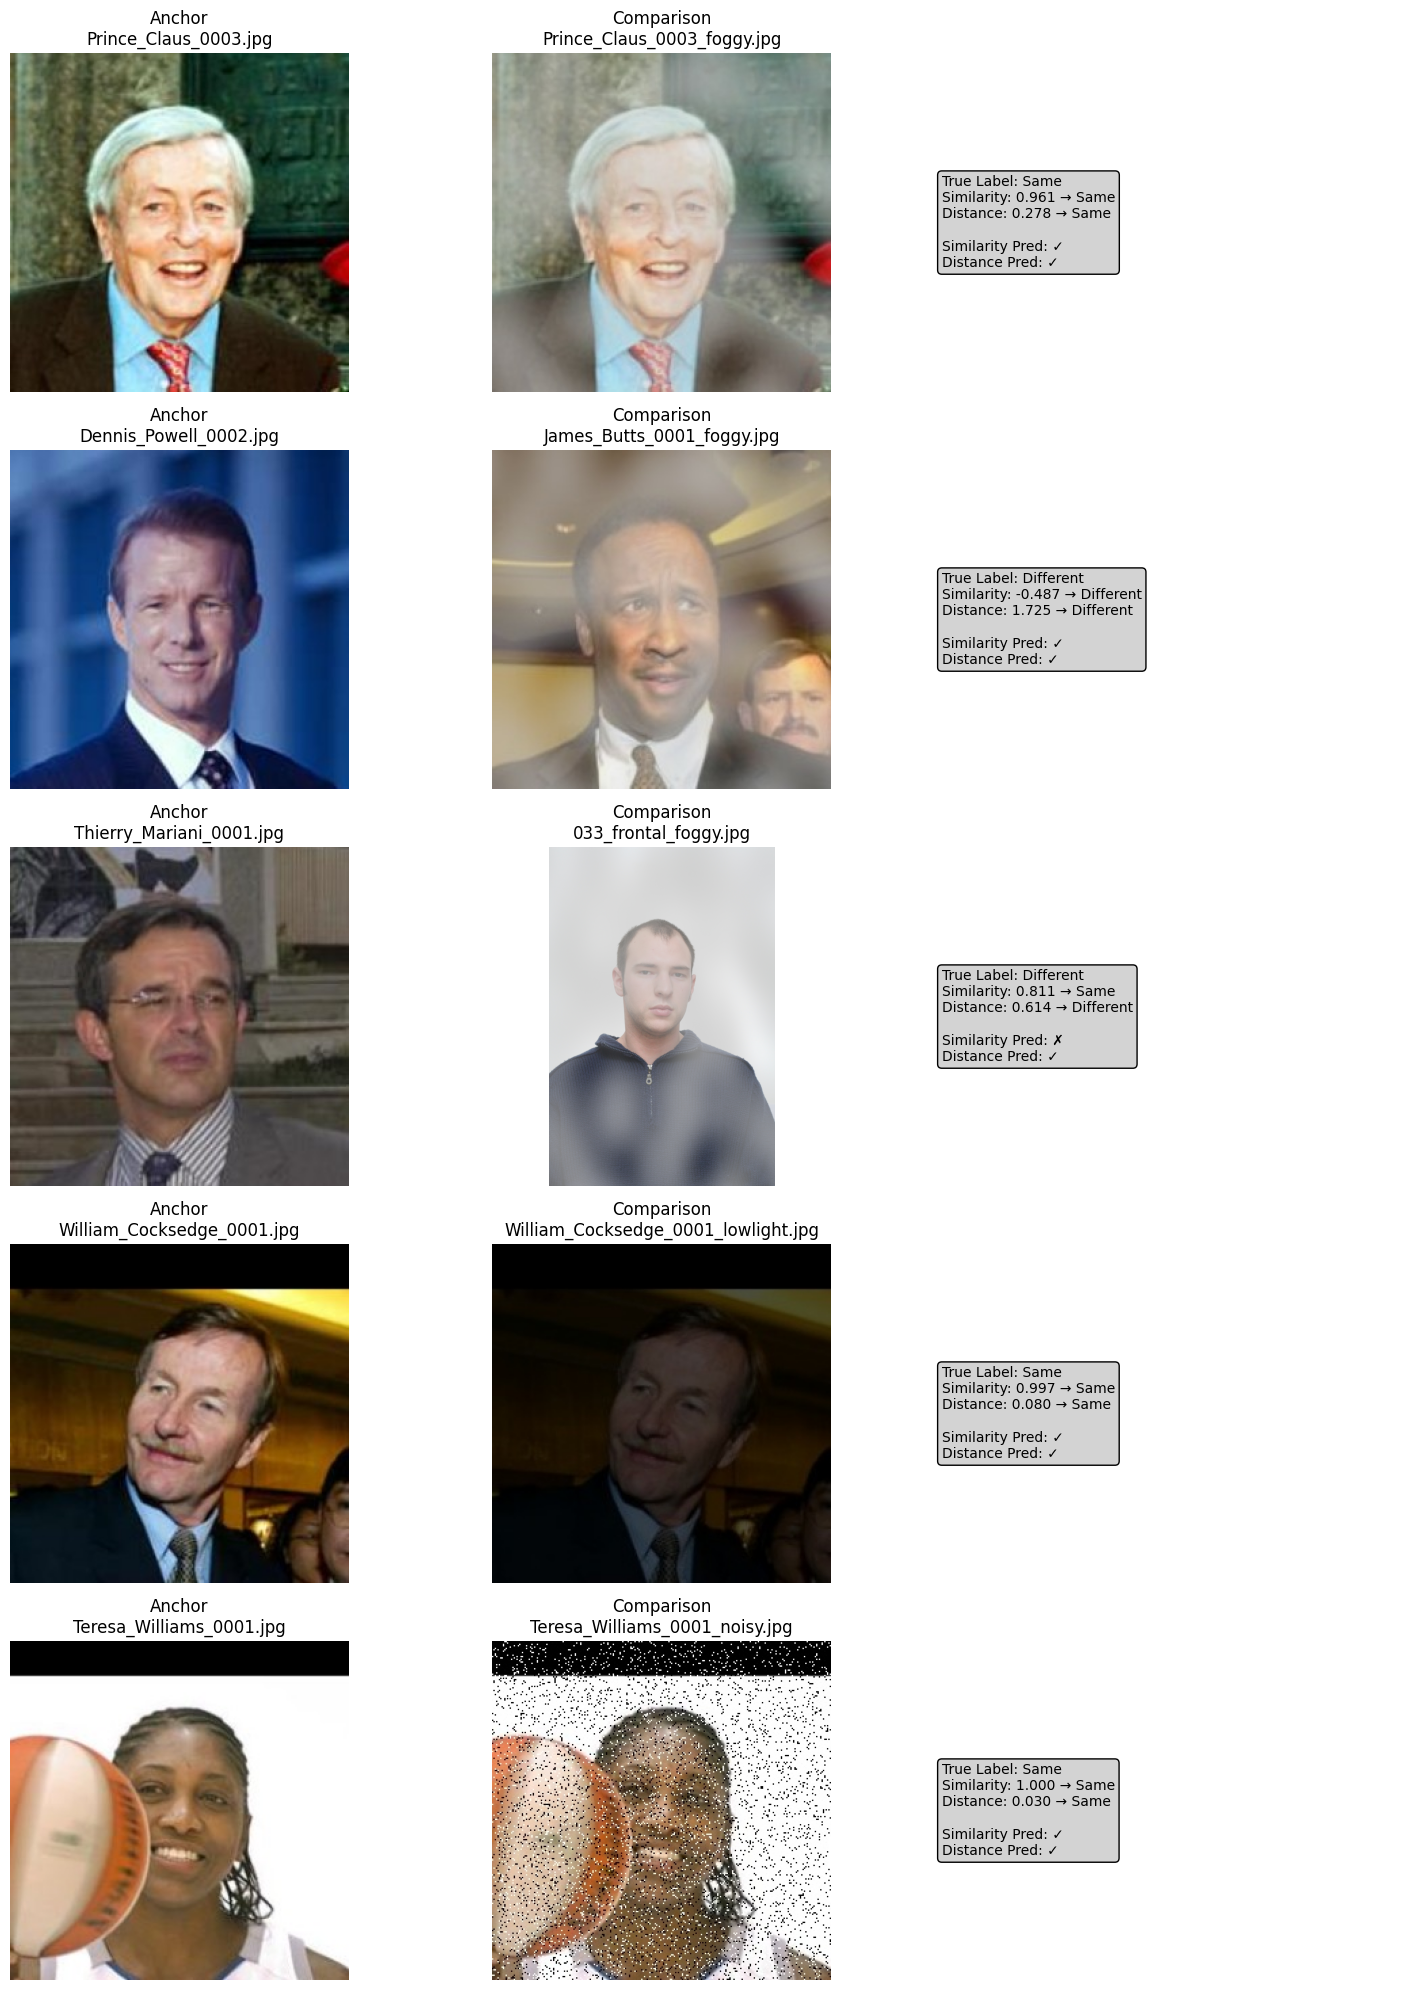

In [ ]:
"""
Fixed Standalone inference code for TaskB Face Recognition
Addresses model loading issues and architecture mismatches
"""

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import random
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import transforms, models
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score
from tqdm import tqdm
import glob
import warnings
warnings.filterwarnings('ignore')


# Configuration
CONFIG = {
    'VAL_DIR': '/content/dataset/Comys_Hackathon5/Task_B/val',
    'BATCH_SIZE': 32,
    'EMBEDDING_DIM': 256,
    'DROPOUT_RATE': 0.3,
    'THRESHOLD': 0.5,
    'DEVICE': 'cuda' if torch.cuda.is_available() else 'cpu'
}

# Model paths
MODEL_PATHS = {
    'Distance Model': 'taskB_best_distance_model.pth',
    'Similarity Model': 'taskB_best_similarity_model.pth',
    'Best Model': 'taskB_best_model.pth',
    'Final Model': 'taskb_best_model_final.pth'
}

# Data transforms
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


class FaceEmbedder(nn.Module):
    """Updated model architecture to handle both ResNet18 and ResNet50 based checkpoints"""
    def __init__(self, embedding_dim=256, dropout_rate=0.3, backbone_type='resnet18'):
        super().__init__()

        self.backbone_type = backbone_type

        # Base feature extractor - flexible backbone
        if backbone_type == 'resnet18':
            backbone = models.resnet18(weights='DEFAULT')
            self.backbone_out_channels = 512
        elif backbone_type == 'resnet50':
            backbone = models.resnet50(weights='DEFAULT')
            self.backbone_out_channels = 2048
        else:
            raise ValueError(f"Unsupported backbone: {backbone_type}")

        # Use features (everything except final FC layer)
        self.features = nn.Sequential(*list(backbone.children())[:-2])

        # Adaptive feature processing
        self.feature_conv = nn.Sequential(
            nn.Conv2d(self.backbone_out_channels, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout2d(dropout_rate)
        )

        # Internal distortion simulation
        self.distortion_sim = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )

        # Attention mechanism
        self.attention_mlp = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(256 * 2, 64, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 2, kernel_size=1),
            nn.Softmax(dim=1)
        )

        # Global pooling and embedding
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.embedding = nn.Sequential(
            nn.Linear(256, embedding_dim),
            nn.BatchNorm1d(embedding_dim),
            nn.Dropout(dropout_rate)
        )

        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                if m.weight is not None:
                    nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, (nn.BatchNorm2d, nn.BatchNorm1d)):
                if m.weight is not None:
                    nn.init.constant_(m.weight, 1)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                if m.weight is not None:
                    nn.init.normal_(m.weight, 0, 0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        feat = self.features(x)
        feat_orig = self.feature_conv(feat)

        # Simulate distortion
        feat_aug = self.distortion_sim(feat_orig)

        # Attention-based fusion
        fusion_input = torch.cat([feat_orig, feat_aug], dim=1)
        att = self.attention_mlp(fusion_input)
        alpha = att[:, 0:1]
        beta = att[:, 1:2]

        fused_feat = alpha * feat_orig + beta * feat_aug

        pooled = self.global_pool(fused_feat).flatten(1)
        embedding = self.embedding(pooled)
        return F.normalize(embedding, p=2, dim=1)


class AlternativeFaceEmbedder(nn.Module):
    """Alternative architecture for models with different structure"""
    def __init__(self, embedding_dim=256, dropout_rate=0.3):
        super().__init__()

        # ResNet50 backbone
        backbone = models.resnet50(weights='DEFAULT')
        self.backbone = nn.Sequential(*list(backbone.children())[:-2])

        # Attention mechanisms
        self.spatial_attention = nn.Sequential(
            nn.Conv2d(2048, 512, kernel_size=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 1, kernel_size=1),
            nn.Sigmoid()
        )

        self.channel_attention = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Linear(2048, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 2048),
            nn.Sigmoid()
        )

        # Embedding head
        self.embedding_head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(2048, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(1024, embedding_dim),
            nn.BatchNorm1d(embedding_dim),
            nn.Dropout(dropout_rate)
        )

    def forward(self, x):
        feat = self.backbone(x)

        # Apply attention
        spatial_att = self.spatial_attention(feat)
        channel_att = self.channel_attention(feat).unsqueeze(-1).unsqueeze(-1)

        attended_feat = feat * spatial_att * channel_att

        embedding = self.embedding_head(attended_feat)
        return F.normalize(embedding, p=2, dim=1)


class FacePairDataset:
    def __init__(self, root, transform, balance_ratio=1.5):
        self.transform = transform
        self.root = root
        self.balance_ratio = balance_ratio
        self.entities = [d for d in os.listdir(root) if os.path.isdir(os.path.join(root, d))]
        self.data = []

        print(f"Found {len(self.entities)} entities")

        positive_count = 0
        negative_count = 0

        for entity in tqdm(self.entities, desc="Loading validation dataset"):
            entity_path = os.path.join(root, entity)
            distortion_path = os.path.join(entity_path, "distortion")

            if not os.path.exists(distortion_path):
                continue

            originals = glob.glob(os.path.join(entity_path, "*.jpg"))
            distorted = glob.glob(os.path.join(distortion_path, "*.jpg"))

            # Positive pairs
            for orig in originals:
                same_dist = [d for d in distorted if
                           os.path.basename(d).startswith(os.path.splitext(os.path.basename(orig))[0])]
                for dimg in same_dist:
                    self.data.append((orig, dimg, 1))
                    positive_count += 1

            # Negative pairs
            for orig in originals:
                for _ in range(int(self.balance_ratio)):
                    neg_entity = random.choice([e for e in self.entities if e != entity])
                    neg_dist_path = os.path.join(root, neg_entity, "distortion")
                    if os.path.exists(neg_dist_path):
                        neg_dist = glob.glob(os.path.join(neg_dist_path, "*.jpg"))
                        if neg_dist:
                            self.data.append((orig, random.choice(neg_dist), 0))
                            negative_count += 1

        print(f"Dataset created: {positive_count} positive, {negative_count} negative pairs")
        print(f"Class balance ratio: {negative_count/positive_count:.2f}")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        anchor_path, comp_path, label = self.data[idx]

        try:
            anchor = Image.open(anchor_path).convert("RGB")
            comp = Image.open(comp_path).convert("RGB")
        except Exception as e:
            print(f"Error loading images: {e}")
            anchor = Image.new('RGB', (224, 224), color='black')
            comp = Image.new('RGB', (224, 224), color='black')
            label = 0

        if self.transform:
            anchor = self.transform(anchor)
            comp = self.transform(comp)

        return anchor, comp, torch.tensor(label, dtype=torch.float32), anchor_path, comp_path


def detect_model_architecture(checkpoint_path):
    """Detect the architecture type from checkpoint keys"""
    try:
        # Load checkpoint with weights_only=False for older models
        checkpoint = torch.load(checkpoint_path, map_location='cpu', weights_only=False)

        if 'model_state_dict' in checkpoint:
            state_dict = checkpoint['model_state_dict']
        else:
            state_dict = checkpoint

        # Check key patterns to determine architecture
        keys = list(state_dict.keys())

        # Check for alternative architecture
        if any('spatial_attention' in key or 'channel_attention' in key for key in keys):
            return 'alternative'

        # Check for ResNet50 (conv3 layers indicate bottleneck blocks)
        if any('conv3' in key for key in keys):
            return 'resnet50'

        # Default to ResNet18
        return 'resnet18'

    except Exception as e:
        print(f"Error detecting architecture: {e}")
        return 'resnet18'


def load_model(model_path, device):
    """Load model with flexible architecture detection"""
    if not os.path.exists(model_path):
        print(f"Model file not found: {model_path}")
        return None, None

    try:
        print(f"Detecting architecture for {model_path}...")
        arch_type = detect_model_architecture(model_path)
        print(f"Detected architecture: {arch_type}")

        # Load checkpoint with weights_only=False for older models
        checkpoint = torch.load(model_path, map_location=device, weights_only=False)

        # Create appropriate model
        if arch_type == 'alternative':
            model = AlternativeFaceEmbedder(
                embedding_dim=CONFIG['EMBEDDING_DIM'],
                dropout_rate=CONFIG['DROPOUT_RATE']
            ).to(device)
        else:
            backbone_type = 'resnet50' if arch_type == 'resnet50' else 'resnet18'
            model = FaceEmbedder(
                embedding_dim=CONFIG['EMBEDDING_DIM'],
                dropout_rate=CONFIG['DROPOUT_RATE'],
                backbone_type=backbone_type
            ).to(device)

        # Load state dict
        if 'model_state_dict' in checkpoint:
            state_dict = checkpoint['model_state_dict']
        else:
            state_dict = checkpoint

        # Try to load with strict=False to handle minor mismatches
        try:
            model.load_state_dict(state_dict, strict=True)
        except RuntimeError as e:
            print(f"Strict loading failed, trying with strict=False: {e}")
            missing_keys, unexpected_keys = model.load_state_dict(state_dict, strict=False)
            if missing_keys:
                print(f"Missing keys: {missing_keys[:5]}...")  # Show first 5
            if unexpected_keys:
                print(f"Unexpected keys: {unexpected_keys[:5]}...")  # Show first 5

        model.eval()
        print(f"Successfully loaded model from {model_path}")
        return model, checkpoint

    except Exception as e:
        print(f"Error loading model {model_path}: {e}")
        return None, None


@torch.no_grad()
def evaluate_model(model, dataloader, device, threshold=0.5):
    """Evaluate model on validation set"""
    model.eval()
    all_embeddings1, all_embeddings2, all_labels = [], [], []
    all_paths = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            anchor, comp, labels, anchor_paths, comp_paths = batch
            anchor, comp, labels = anchor.to(device), comp.to(device), labels.to(device)

            try:
                emb1 = model(anchor)
                emb2 = model(comp)

                all_embeddings1.append(emb1)
                all_embeddings2.append(emb2)
                all_labels.append(labels)
                all_paths.extend(list(zip(anchor_paths, comp_paths)))
            except Exception as e:
                print(f"Error during inference: {e}")
                continue

    if not all_embeddings1:
        print("No successful evaluations!")
        return None

    all_embeddings1 = torch.cat(all_embeddings1)
    all_embeddings2 = torch.cat(all_embeddings2)
    all_labels = torch.cat(all_labels)

    # Calculate similarities and distances
    similarities = F.cosine_similarity(all_embeddings1, all_embeddings2)
    distances = F.pairwise_distance(all_embeddings1, all_embeddings2)

    # Predictions
    sim_preds = (similarities > threshold).long()
    dist_preds = (distances < threshold).long()

    # Convert to numpy for sklearn
    labels_np = all_labels.cpu().numpy()
    sim_preds_np = sim_preds.cpu().numpy()
    dist_preds_np = dist_preds.cpu().numpy()
    similarities_np = similarities.cpu().numpy()
    distances_np = distances.cpu().numpy()

    # Calculate metrics for similarity-based predictions
    sim_acc = accuracy_score(labels_np, sim_preds_np)
    sim_prec, sim_rec, sim_f1, _ = precision_recall_fscore_support(
        labels_np, sim_preds_np, average='binary', zero_division=0
    )
    _, _, sim_macro_f1, _ = precision_recall_fscore_support(
        labels_np, sim_preds_np, average='macro', zero_division=0
    )

    # Calculate metrics for distance-based predictions
    dist_acc = accuracy_score(labels_np, dist_preds_np)
    dist_prec, dist_rec, dist_f1, _ = precision_recall_fscore_support(
        labels_np, dist_preds_np, average='binary', zero_division=0
    )
    _, _, dist_macro_f1, _ = precision_recall_fscore_support(
        labels_np, dist_preds_np, average='macro', zero_division=0
    )

    # Calculate AUC
    try:
        sim_auc = roc_auc_score(labels_np, similarities_np)
        dist_auc = roc_auc_score(labels_np, -distances_np)
    except ValueError:
        sim_auc = 0.5
        dist_auc = 0.5

    return {
        'similarity': {
            'accuracy': sim_acc,
            'precision': sim_prec,
            'recall': sim_rec,
            'f1': sim_f1,
            'macro_f1': sim_macro_f1,
            'auc': sim_auc
        },
        'distance': {
            'accuracy': dist_acc,
            'precision': dist_prec,
            'recall': dist_rec,
            'f1': dist_f1,
            'macro_f1': dist_macro_f1,
            'auc': dist_auc
        },
        'predictions': {
            'similarities': similarities_np,
            'distances': distances_np,
            'sim_preds': sim_preds_np,
            'dist_preds': dist_preds_np,
            'labels': labels_np,
            'paths': all_paths
        }
    }


def display_sample_predictions(predictions, num_samples=5):
    """Display random sample predictions with images"""
    if predictions is None:
        print("No predictions to display")
        return

    data = predictions['predictions']
    indices = random.sample(range(len(data['labels'])), min(num_samples, len(data['labels'])))

    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 4 * num_samples))
    if num_samples == 1:
        axes = axes.reshape(1, -1)

    for i, idx in enumerate(indices):
        anchor_path, comp_path = data['paths'][idx]
        true_label = data['labels'][idx]
        sim_pred = data['sim_preds'][idx]
        dist_pred = data['dist_preds'][idx]
        similarity = data['similarities'][idx]
        distance = data['distances'][idx]

        # Load and display images
        try:
            anchor_img = Image.open(anchor_path).convert("RGB")
            comp_img = Image.open(comp_path).convert("RGB")
        except:
            anchor_img = Image.new('RGB', (224, 224), color='black')
            comp_img = Image.new('RGB', (224, 224), color='black')

        # Display anchor image
        axes[i, 0].imshow(anchor_img)
        axes[i, 0].set_title(f"Anchor\n{os.path.basename(anchor_path)}")
        axes[i, 0].axis('off')

        # Display comparison image
        axes[i, 1].imshow(comp_img)
        axes[i, 1].set_title(f"Comparison\n{os.path.basename(comp_path)}")
        axes[i, 1].axis('off')

        # Display predictions
        axes[i, 2].axis('off')
        pred_text = f"True Label: {'Same' if true_label == 1 else 'Different'}\n"
        pred_text += f"Similarity: {similarity:.3f} → {'Same' if sim_pred == 1 else 'Different'}\n"
        pred_text += f"Distance: {distance:.3f} → {'Same' if dist_pred == 1 else 'Different'}\n\n"

        # Color code based on correctness
        sim_correct = "✓" if sim_pred == true_label else "✗"
        dist_correct = "✓" if dist_pred == true_label else "✗"

        pred_text += f"Similarity Pred: {sim_correct}\n"
        pred_text += f"Distance Pred: {dist_correct}"

        axes[i, 2].text(0.1, 0.5, pred_text, transform=axes[i, 2].transAxes,
                       fontsize=10, verticalalignment='center',
                       bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))

    plt.tight_layout()
    plt.show()


def main():
    """Main inference function"""
    print("TaskB Face Recognition - Fixed Model Inference")
    print("=" * 60)

    device = torch.device(CONFIG['DEVICE'])
    print(f"Using device: {device}")

    # Load validation dataset
    print("\nLoading validation dataset...")
    val_dataset = FacePairDataset(CONFIG['VAL_DIR'], val_transform)
    val_loader = DataLoader(val_dataset, batch_size=CONFIG['BATCH_SIZE'], shuffle=False)

    # Evaluate all models
    results = {}

    for model_name, model_path in MODEL_PATHS.items():
        print(f"\n{'='*60}")
        print(f"Evaluating {model_name}")
        print(f"{'='*60}")

        model, checkpoint = load_model(model_path, device)
        if model is None:
            print(f"Skipping {model_name} - failed to load")
            continue

        # Show model info from checkpoint
        if checkpoint:
            print(f"Model epoch: {checkpoint.get('epoch', 'N/A')}")
            if 'best_sim_f1' in checkpoint:
                print(f"Best similarity F1: {checkpoint['best_sim_f1']:.4f}")
            if 'best_dist_f1' in checkpoint:
                print(f"Best distance F1: {checkpoint['best_dist_f1']:.4f}")

        # Evaluate model
        metrics = evaluate_model(model, val_loader, device, CONFIG['THRESHOLD'])
        if metrics is None:
            print(f"Evaluation failed for {model_name}")
            continue

        results[model_name] = metrics

        # Display results
        print(f"\nSimilarity-based metrics:")
        print(f"  Accuracy: {metrics['similarity']['accuracy']:.4f}")
        print(f"  Precision: {metrics['similarity']['precision']:.4f}")
        print(f"  Recall: {metrics['similarity']['recall']:.4f}")
        print(f"  F1: {metrics['similarity']['f1']:.4f}")
        print(f"  Macro F1: {metrics['similarity']['macro_f1']:.4f}")
        print(f"  AUC: {metrics['similarity']['auc']:.4f}")

        print(f"\nDistance-based metrics:")
        print(f"  Accuracy: {metrics['distance']['accuracy']:.4f}")
        print(f"  Precision: {metrics['distance']['precision']:.4f}")
        print(f"  Recall: {metrics['distance']['recall']:.4f}")
        print(f"  F1: {metrics['distance']['f1']:.4f}")
        print(f"  Macro F1: {metrics['distance']['macro_f1']:.4f}")
        print(f"  AUC: {metrics['distance']['auc']:.4f}")

    # Create comparison table
    if results:
        print(f"\n{'='*60}")
        print("MODEL COMPARISON SUMMARY")
        print(f"{'='*60}")

        comparison_data = []
        for model_name, metrics in results.items():
            comparison_data.append({
                'Model': model_name,
                'Sim_Acc': metrics['similarity']['accuracy'],
                'Sim_F1': metrics['similarity']['f1'],
                'Sim_Macro_F1': metrics['similarity']['macro_f1'],
                'Sim_AUC': metrics['similarity']['auc'],
                'Dist_Acc': metrics['distance']['accuracy'],
                'Dist_F1': metrics['distance']['f1'],
                'Dist_Macro_F1': metrics['distance']['macro_f1'],
                'Dist_AUC': metrics['distance']['auc']
            })

        df = pd.DataFrame(comparison_data)
        print(df.to_string(index=False, float_format='%.4f'))

        # Save results to CSV
        df.to_csv('model_comparison_results.csv', index=False)
        print(f"\nResults saved to 'model_comparison_results.csv'")

        # Display sample predictions from the best model
        best_model_name = max(results.keys(),
                            key=lambda x: max(results[x]['similarity']['f1'],
                                            results[x]['distance']['f1']))

        print(f"\n{'='*60}")
        print(f"SAMPLE PREDICTIONS FROM BEST MODEL: {best_model_name}")
        print(f"{'='*60}")

        display_sample_predictions(results[best_model_name], num_samples=5)
    else:
        print("No models could be loaded successfully.")


if __name__ == "__main__":
    main()

## Only For Experiment Purpose

In [10]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from PIL import Image
import random
import glob
from tqdm import tqdm
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, roc_auc_score
import pandas as pd
import csv
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import torchvision.transforms.functional as TF
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
import warnings
warnings.filterwarnings('ignore')


CONFIG = {
    'EPOCHS': 50,
    'BATCH_SIZE': 32,
    'LEARNING_RATE': 3e-4,
    'WEIGHT_DECAY': 1e-4,
    'PATIENCE': 8,
    'MARGIN': 1.2,
    'ALPHA': 0.2,
    'GAMMA': 2,
    'WARMUP_EPOCHS': 5,
    'TRAIN_DIR': '/content/dataset/Comys_Hackathon5/Task_B/train',
    'VAL_DIR': '/content/dataset/Comys_Hackathon5/Task_B/val',
    'MODEL_PATH': 'taskB_best_model.pth',
    'SIMILARITY_MODEL_PATH': 'taskB_best_similarity_model.pth',
    'DISTANCE_MODEL_PATH': 'taskB_best_distance_model.pth',
    'OPTIMAL_SIM_MODEL_PATH': 'taskB_optimal_similarity_model.pth',
    'OPTIMAL_DIST_MODEL_PATH': 'taskB_optimal_distance_model.pth',
    'CSV_LOG_PATH': 'taskB_metrics_log.csv',
    'THRESHOLD': 0.5,
    'THRESHOLD_SEARCH_RANGE': (0.1, 0.9),
    'THRESHOLD_SEARCH_STEPS': 20,
    'EMBEDDING_DIM': 256,
    'DROPOUT_RATE': 0.3,
    'USE_MIXUP': False,
    'MIXUP_ALPHA': 0.4,
    'TRAIN_EVAL_FREQUENCY': 2  # Evaluate training metrics every N epochs
}

class NoiseLayer(nn.Module):
    def __init__(self, std=0.02):
        super().__init__()
        self.std = std

    def forward(self, x):
        if self.training:
            return x + torch.randn_like(x) * self.std
        return x

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

class FacePairDataset(Dataset):
    def __init__(self, root, transform, is_training=True, balance_ratio=1.5):
        self.transform = transform
        self.root = root
        self.is_training = is_training
        self.balance_ratio = balance_ratio
        self.entities = [d for d in os.listdir(root) if os.path.isdir(os.path.join(root, d))]
        self.data = []
        self.weights = []

        print(f"Found {len(self.entities)} entities")

        positive_count = 0
        negative_count = 0

        for entity in tqdm(self.entities, desc="Loading dataset"):
            entity_path = os.path.join(root, entity)
            distortion_path = os.path.join(entity_path, "distortion")

            if not os.path.exists(distortion_path):
                continue

            originals = glob.glob(os.path.join(entity_path, "*.jpg"))
            distorted = glob.glob(os.path.join(distortion_path, "*.jpg"))

            for orig in originals:
                same_dist = [d for d in distorted if
                           os.path.basename(d).startswith(os.path.splitext(os.path.basename(orig))[0])]
                for dimg in same_dist:
                    self.data.append((orig, dimg, 1))
                    positive_count += 1

                for _ in range(int(self.balance_ratio)):
                    neg_entity = random.choice([e for e in self.entities if e != entity])
                    neg_dist_path = os.path.join(root, neg_entity, "distortion")
                    if os.path.exists(neg_dist_path):
                        neg_dist = glob.glob(os.path.join(neg_dist_path, "*.jpg"))
                        if neg_dist:
                            self.data.append((orig, random.choice(neg_dist), 0))
                            negative_count += 1

        total_pos = positive_count
        total_neg = negative_count

        for _, _, label in self.data:
            if label == 1:
                self.weights.append(1.0 / total_pos)
            else:
                self.weights.append(1.0 / total_neg)

        print(f"Dataset created: {positive_count} positive, {negative_count} negative pairs")
        print(f"Class balance ratio: {negative_count/positive_count:.2f}")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        anchor_path, comp_path, label = self.data[idx]

        try:
            anchor = Image.open(anchor_path).convert("RGB")
            comp = Image.open(comp_path).convert("RGB")
        except Exception as e:
            print(f"Error loading images: {e}")
            anchor = Image.new('RGB', (224, 224), color='black')
            comp = Image.new('RGB', (224, 224), color='black')
            label = 0

        if self.transform:
            anchor = self.transform(anchor)
            comp = self.transform(comp)

        return anchor, comp, torch.tensor(label, dtype=torch.float32)


class FaceEmbedder(nn.Module):
    def __init__(self, embedding_dim=256, dropout_rate=0.3):
        super().__init__()

        # Base feature extractor
        backbone = models.resnet18(weights='DEFAULT')
        self.features = nn.Sequential(*list(backbone.children())[:-2])
        self.backbone_out_channels = 512

        # Shallow transform for original and distorted
        self.feature_conv = nn.Sequential(
            nn.Conv2d(self.backbone_out_channels, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout2d(dropout_rate)
        )

        # Internal distortion simulation (1x1 conv)
        self.distortion_sim = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )

        # Learnable attention for multi-view fusion
        self.attention_mlp = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(256 * 2, 64, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 2, kernel_size=1),
            nn.Softmax(dim=1)
        )

        # Global pooling and embedding head
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.embedding = nn.Sequential(
            nn.Linear(256, embedding_dim),
            nn.BatchNorm1d(embedding_dim),
            nn.Dropout(dropout_rate)
        )

        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                if m.weight is not None:
                    nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, (nn.BatchNorm2d, nn.BatchNorm1d)):
                if m.weight is not None:
                    nn.init.constant_(m.weight, 1)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                if m.weight is not None:
                    nn.init.normal_(m.weight, 0, 0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        feat = self.features(x)                # [B, 512, H, W]
        feat_orig = self.feature_conv(feat)    # [B, 256, H, W]

        # Simulate distortion
        feat_aug = self.distortion_sim(feat_orig)

        # Concatenate and compute attention weights
        fusion_input = torch.cat([feat_orig.unsqueeze(1), feat_aug.unsqueeze(1)], dim=1)  # [B, 2, 256, H, W]
        fusion_input = fusion_input.view(x.size(0), 512, feat_orig.size(2), feat_orig.size(3))  # [B, 512, H, W]

        att = self.attention_mlp(fusion_input)  # [B, 2, 1, 1]
        alpha = att[:, 0:1]                     # attention for orig
        beta = att[:, 1:2]                      # attention for aug

        fused_feat = alpha * feat_orig + beta * feat_aug

        pooled = self.global_pool(fused_feat).flatten(1)
        embedding = self.embedding(pooled)
        return F.normalize(embedding, p=2, dim=1)

class TripletMarginLoss(nn.Module):
    def __init__(self, margin=1.0):
        super().__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        distance_positive = F.pairwise_distance(anchor, positive)
        distance_negative = F.pairwise_distance(anchor, negative)
        losses = F.relu(distance_positive - distance_negative + self.margin)
        return losses.mean()

class HybridLoss(nn.Module):
    def __init__(self, margin=1.0, alpha=0.7):
        super().__init__()
        self.margin = margin
        self.alpha = alpha

    def forward(self, emb1, emb2, labels):
        distances = F.pairwise_distance(emb1, emb2)
        contrastive = torch.mean(
            labels * distances**2 +
            (1 - labels) * F.relu(self.margin - distances)**2
        )

        cos_sim = F.cosine_similarity(emb1, emb2)
        cosine_loss = torch.mean(
            labels * (1 - cos_sim) +
            (1 - labels) * F.relu(cos_sim + 0.1)
        )

        return self.alpha * contrastive + (1 - self.alpha) * cosine_loss

def mixup_pairs(x1, x2, y, alpha=1.0):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x1.size(0)
    index = torch.randperm(batch_size).to(x1.device)

    mixed_x1 = lam * x1 + (1 - lam) * x1[index]
    mixed_x2 = lam * x2 + (1 - lam) * x2[index]
    y_a, y_b = y, y[index]

    return mixed_x1, mixed_x2, y_a, y_b, lam

def mixup_loss(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

@torch.no_grad()
def evaluate_model(model, dataloader, device, sim_threshold=0.5, dist_threshold=0.5):
    model.eval()

    all_embeddings1, all_embeddings2, labels = [], [], []
    ProgressBar=tqdm(dataloader, desc="Evaluating")
    with torch.no_grad():
        for batch in dataloader:
            anchor, comp, batch_labels = [x.to(device) for x in batch]

            emb1 = model(anchor)
            emb2 = model(comp)

            all_embeddings1.append(emb1)
            all_embeddings2.append(emb2)
            labels.append(batch_labels)

    all_embeddings1 = torch.cat(all_embeddings1)
    all_embeddings2 = torch.cat(all_embeddings2)
    labels = torch.cat(labels)

    similarities = F.cosine_similarity(all_embeddings1, all_embeddings2)
    distances = F.pairwise_distance(all_embeddings1, all_embeddings2)

    sim_preds = (similarities > sim_threshold).long()
    dist_preds = (distances < dist_threshold).long()

    # Distance-based metrics
    dist_acc = accuracy_score(labels.cpu(), dist_preds.cpu())
    dist_prec, dist_rec, dist_f1, _ = precision_recall_fscore_support(
        labels.cpu(), dist_preds.cpu(), average='binary', zero_division=0
    )
    _, _, dist_macro_f1, _ = precision_recall_fscore_support(
        labels.cpu(), dist_preds.cpu(), average='macro', zero_division=0
    )

    # Similarity-based metrics
    sim_acc = accuracy_score(labels.cpu(), sim_preds.cpu())
    sim_prec, sim_rec, sim_f1, _ = precision_recall_fscore_support(
        labels.cpu(), sim_preds.cpu(), average='binary', zero_division=0
    )
    _, _, sim_macro_f1, _ = precision_recall_fscore_support(
        labels.cpu(), sim_preds.cpu(), average='macro', zero_division=0
    )

    # AUC scores
    try:
        dist_auc = roc_auc_score(labels.cpu(), -distances.cpu())
        sim_auc = roc_auc_score(labels.cpu(), similarities.cpu())
    except ValueError:
        dist_auc = 0.5
        sim_auc = 0.5

    return {
        'dist_acc': dist_acc, 'dist_prec': dist_prec, 'dist_rec': dist_rec,
        'dist_f1': dist_f1, 'dist_macro_f1': dist_macro_f1, 'dist_auc': dist_auc,
        'sim_acc': sim_acc, 'sim_prec': sim_prec, 'sim_rec': sim_rec,
        'sim_f1': sim_f1, 'sim_macro_f1': sim_macro_f1, 'sim_auc': sim_auc,
        'sim_threshold': sim_threshold, 'dist_threshold': dist_threshold
    }

@torch.no_grad()
def optimize_thresholds(model, dataloader, device, threshold_range=(0.1, 0.9), steps=50, metric='f1'):
    model.eval()
    all_embeddings1, all_embeddings2, labels = [], [], []

    with torch.no_grad():
        for batch in dataloader:
            anchor, comp, batch_labels = [x.to(device) for x in batch]
            emb1 = model(anchor)
            emb2 = model(comp)
            all_embeddings1.append(emb1)
            all_embeddings2.append(emb2)
            labels.append(batch_labels)

    all_embeddings1 = torch.cat(all_embeddings1)
    all_embeddings2 = torch.cat(all_embeddings2)
    labels = torch.cat(labels).cpu().numpy()

    similarities = F.cosine_similarity(all_embeddings1, all_embeddings2).cpu().numpy()
    distances = F.pairwise_distance(all_embeddings1, all_embeddings2).cpu().numpy()

    thresholds = np.linspace(threshold_range[0], threshold_range[1], steps)

    best_sim_threshold = threshold_range[0]
    best_sim_score = 0
    best_sim_metrics = {}

    best_dist_threshold = threshold_range[0]
    best_dist_score = 0
    best_dist_metrics = {}

    sim_threshold_results = []
    dist_threshold_results = []

    print("Optimizing similarity threshold...")
    for threshold in tqdm(thresholds, desc="Similarity thresholds"):
        sim_preds = (similarities > threshold).astype(int)

        acc = accuracy_score(labels, sim_preds)
        prec, rec, f1, _ = precision_recall_fscore_support(labels, sim_preds, average='binary', zero_division=0)
        _, _, macro_f1, _ = precision_recall_fscore_support(labels, sim_preds, average='macro', zero_division=0)

        metrics = {
            'threshold': threshold,
            'accuracy': acc,
            'precision': prec,
            'recall': rec,
            'f1': f1,
            'macro_f1': macro_f1
        }
        sim_threshold_results.append(metrics)

        if metric == 'f1':
            score = f1
        elif metric == 'macro_f1':
            score = macro_f1
        elif metric == 'accuracy':
            score = acc
        else:
            score = f1

        if score > best_sim_score:
            best_sim_score = score
            best_sim_threshold = threshold
            best_sim_metrics = metrics.copy()

    print("Optimizing distance threshold...")
    for threshold in tqdm(thresholds, desc="Distance thresholds"):
        dist_preds = (distances < threshold).astype(int)

        acc = accuracy_score(labels, dist_preds)
        prec, rec, f1, _ = precision_recall_fscore_support(labels, dist_preds, average='binary', zero_division=0)
        _, _, macro_f1, _ = precision_recall_fscore_support(labels, dist_preds, average='macro', zero_division=0)

        metrics = {
            'threshold': threshold,
            'accuracy': acc,
            'precision': prec,
            'recall': rec,
            'f1': f1,
            'macro_f1': macro_f1
        }
        dist_threshold_results.append(metrics)

        if metric == 'f1':
            score = f1
        elif metric == 'macro_f1':
            score = macro_f1
        elif metric == 'accuracy':
            score = acc
        else:
            score = f1

        if score > best_dist_score:
            best_dist_score = score
            best_dist_threshold = threshold
            best_dist_metrics = metrics.copy()

    return {
        'similarity': {
            'optimal_threshold': best_sim_threshold,
            'best_metrics': best_sim_metrics,
            'all_results': sim_threshold_results
        },
        'distance': {
            'optimal_threshold': best_dist_threshold,
            'best_metrics': best_dist_metrics,
            'all_results': dist_threshold_results
        }
    }

def train_model(model, train_loader, val_loader, optimizer, device, config):
    criterion = HybridLoss(margin=config['MARGIN'])
    scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)

    best_sim_f1 = 0
    best_sim_macro_f1 = 0
    best_dist_f1 = 0
    best_dist_macro_f1 = 0
    best_val_loss = float('inf')

    early_stop_counter = 0
    metrics_history = []

    os.makedirs("checkpoints", exist_ok=True)

    for epoch in range(1, config['EPOCHS'] + 1):
        model.train()
        total_loss = 0
        num_batches = 0

        print(f"\n{'='*50}")
        print(f"Epoch {epoch}/{config['EPOCHS']}")
        print(f"{'='*50}")

        progress_bar = tqdm(train_loader, desc="Training")

        for batch_idx, (anchor, comp, label) in enumerate(progress_bar):
            anchor, comp, label = anchor.to(device), comp.to(device), label.to(device)

            emb1, emb2 = model(anchor), model(comp)
            loss = criterion(emb1, emb2, label)

            optimizer.zero_grad()
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()
            scheduler.step(epoch + batch_idx / len(train_loader))

            total_loss += loss.item()
            num_batches += 1

            if batch_idx % 50 == 0:
                torch.cuda.empty_cache()

            progress_bar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Avg Loss': f'{total_loss/num_batches:.4f}',
                'LR': f'{optimizer.param_groups[0]["lr"]:.2e}'
            })

        torch.cuda.empty_cache()

        avg_train_loss = total_loss / len(train_loader)

        # Evaluate training metrics every N epochs
        train_metrics = {}
        if epoch % config['TRAIN_EVAL_FREQUENCY'] == 0 or epoch == 1:
            print("Evaluating training metrics...")
            train_metrics = evaluate_model(model, train_loader, device, config['THRESHOLD'])

            print(f"Training Metrics (Epoch {epoch}):")
            print(f"  Distance-based - Acc: {train_metrics['dist_acc']:.4f}, P: {train_metrics['dist_prec']:.4f}, R: {train_metrics['dist_rec']:.4f}, F1: {train_metrics['dist_f1']:.4f}, Macro F1: {train_metrics['dist_macro_f1']:.4f}")
            print(f"  Similarity-based - Acc: {train_metrics['sim_acc']:.4f}, P: {train_metrics['sim_prec']:.4f}, R: {train_metrics['sim_rec']:.4f}, F1: {train_metrics['sim_f1']:.4f}, Macro F1: {train_metrics['sim_macro_f1']:.4f}")

        # Evaluate validation metrics
        val_metrics = evaluate_model(model, val_loader, device, config['THRESHOLD'])

        # Calculate validation loss
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for anchor, comp, label in val_loader:
                anchor, comp, label = anchor.to(device), comp.to(device), label.to(device)
                emb1, emb2 = model(anchor), model(comp)
                loss = criterion(emb1, emb2, label)
                val_loss += loss.item()
        avg_val_loss = val_loss / len(val_loader)

        torch.cuda.empty_cache()

        print(f"\nEpoch {epoch} Results:")
        print(f"Train Loss: {avg_train_loss:.4f}")
        print(f"Validation Loss: {avg_val_loss:.4f}")
        print(f"training metrics: {train_metrics}")
        print(f"Validation Distance-based - Acc: {val_metrics['dist_acc']:.4f}, P: {val_metrics['dist_prec']:.4f}, R: {val_metrics['dist_rec']:.4f}, F1: {val_metrics['dist_f1']:.4f}, Macro F1: {val_metrics['dist_macro_f1']:.4f}")
        print(f"Validation Similarity-based - Acc: {val_metrics['sim_acc']:.4f}, P: {val_metrics['sim_prec']:.4f}, R: {val_metrics['sim_rec']:.4f}, F1: {val_metrics['sim_f1']:.4f}, Macro F1: {val_metrics['sim_macro_f1']:.4f}")

        # Create comprehensive metrics dictionary
        metrics = {
    'epoch': epoch,
    'train_loss': avg_train_loss,
    'val_loss': avg_val_loss,
    'learning_rate': optimizer.param_groups[0]['lr'],
    # Validation metrics
    **{f'val_{k}': v for k, v in val_metrics.items()}
}

# Add training metrics if available
        if train_metrics:
          metrics.update({f'train_{k}': v for k, v in train_metrics.items()})


        # Add empty training metrics for epochs where they weren't calculated
        if not train_metrics:
            for key in ['dist_acc', 'dist_prec', 'dist_rec', 'dist_f1', 'dist_macro_f1', 'dist_auc',
                       'sim_acc', 'sim_prec', 'sim_rec', 'sim_f1', 'sim_macro_f1', 'sim_auc']:
                metrics[f'train_{key}'] = None

        metrics_history.append(metrics)

        # Save metrics to CSV
        df = pd.DataFrame([metrics])
        if epoch == 1:
            df.to_csv(config['CSV_LOG_PATH'], index=False)
        else:
            df.to_csv(config['CSV_LOG_PATH'], mode='a', header=False, index=False)

        # Model saving logic
        sim_improved = False
        dist_improved = False
        val_loss_improved = False

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            val_loss_improved = True

        if val_metrics['sim_f1'] > best_sim_f1:
            best_sim_f1 = val_metrics['sim_f1']
            sim_improved = True

            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_sim_f1': best_sim_f1,
                'best_sim_macro_f1': val_metrics['sim_macro_f1'],
                'metrics': val_metrics,
                'config': config,
                'model_type': 'similarity'
            }, config['SIMILARITY_MODEL_PATH'])

            print(f"New best similarity model saved with F1: {best_sim_f1:.4f}, Macro F1: {val_metrics['sim_macro_f1']:.4f}")

        if val_metrics['dist_f1'] > best_dist_f1:
            best_dist_f1 = val_metrics['dist_f1']
            dist_improved = True

            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_dist_f1': best_dist_f1,
                'best_dist_macro_f1': val_metrics['dist_macro_f1'],
                'metrics': val_metrics,
                'config': config,
                'model_type': 'distance'
            }, config['DISTANCE_MODEL_PATH'])

            print(f"New best distance model saved with F1: {best_dist_f1:.4f}, Macro F1: {val_metrics['dist_macro_f1']:.4f}")

        if val_metrics['sim_macro_f1'] > best_sim_macro_f1:
            best_sim_macro_f1 = val_metrics['sim_macro_f1']

        if val_metrics['dist_macro_f1'] > best_dist_macro_f1:
            best_dist_macro_f1 = val_metrics['dist_macro_f1']

        current_best_f1 = max(val_metrics['sim_f1'], val_metrics['dist_f1'])
        overall_best_f1 = max(best_sim_f1, best_dist_f1)

        if current_best_f1 >= overall_best_f1:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_sim_f1': best_sim_f1,
                'best_dist_f1': best_dist_f1,
                'best_sim_macro_f1': best_sim_macro_f1,
                'best_dist_macro_f1': best_dist_macro_f1,
                'metrics': val_metrics,
                'config': config,
                'model_type': 'overall_best'
            }, config['MODEL_PATH'])

        # Early stopping logic
        if sim_improved or dist_improved or val_loss_improved:
            early_stop_counter = 0
        else:
            early_stop_counter += 1

            if epoch % 5 == 0:
                ckpt_path = f"checkpoints/epoch_{epoch:03d}_simF1_{val_metrics['sim_f1']:.4f}_distF1_{val_metrics['dist_f1']:.4f}_valLoss_{avg_val_loss:.4f}.pth"
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'metrics': val_metrics,
                    'config': config
                }, ckpt_path)

            if early_stop_counter >= config['PATIENCE']:
                print(f"Early stopping triggered after {config['PATIENCE']} epochs without improvement in F1 scores or validation loss")
                print(f"Best validation loss: {best_val_loss:.4f}")
                break

    # Save final model
    final_path = config['MODEL_PATH'].replace('.pth', '_final.pth')
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'final_metrics': val_metrics,
        'best_sim_f1': best_sim_f1,
        'best_dist_f1': best_dist_f1,
        'best_sim_macro_f1': best_sim_macro_f1,
        'best_dist_macro_f1': best_dist_macro_f1,
        'best_val_loss': best_val_loss,
        'config': config
    }, final_path)

    print(f"\nTraining completed!")
    print(f"Best Validation Loss: {best_val_loss:.4f}")
    print(f"Best Similarity F1: {best_sim_f1:.4f}, Macro F1: {best_sim_macro_f1:.4f}")
    print(f"Best Distance F1: {best_dist_f1:.4f}, Macro F1: {best_dist_macro_f1:.4f}")

    return metrics_history
def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    torch.manual_seed(42)
    np.random.seed(42)
    random.seed(42)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(42)

    model = FaceEmbedder(
        embedding_dim=CONFIG['EMBEDDING_DIM'],
        dropout_rate=CONFIG['DROPOUT_RATE']
    ).to(device)

    print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

    print("Creating datasets...")
    train_dataset = FacePairDataset(
        CONFIG['TRAIN_DIR'], train_transform, is_training=True
    )
    val_dataset = FacePairDataset(
        CONFIG['VAL_DIR'], val_transform, is_training=False
    )

    sampler = WeightedRandomSampler(
        weights=train_dataset.weights,
        num_samples=len(train_dataset),
        replacement=True
    )

    train_loader = DataLoader(
        train_dataset,
        batch_size=CONFIG['BATCH_SIZE'],
        sampler=sampler,
        num_workers=2,
        pin_memory=False
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=CONFIG['BATCH_SIZE'],
        shuffle=False,
        num_workers=2,
        pin_memory=False
    )

    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=CONFIG['LEARNING_RATE'],
        weight_decay=CONFIG['WEIGHT_DECAY']
    )

    print("Starting training...")
    metrics_history = train_model(
        model, train_loader, val_loader, optimizer, device, CONFIG
    )
  #printing training metrics
    df = pd.DataFrame(metrics_history)
    print(df)
    df.to_csv(CONFIG['CSV_LOG_PATH'], index=False)
    print(f"Metrics saved to: {CONFIG['CSV_LOG_PATH']}")

    print("Training completed successfully!")
    print(f"Metrics saved to: {CONFIG['CSV_LOG_PATH']}")
    print(f"Best overall model saved to: {CONFIG['MODEL_PATH']}")
    print(f"Best similarity model saved to: {CONFIG['SIMILARITY_MODEL_PATH']}")
    print(f"Best distance model saved to: {CONFIG['DISTANCE_MODEL_PATH']}")

if __name__ == "__main__":
    main()

Using device: cuda
Model parameters: 12,522,498
Creating datasets...
Found 877 entities


Loading dataset: 100%|██████████| 877/877 [00:00<00:00, 953.43it/s] 


Dataset created: 13482 positive, 1926 negative pairs
Class balance ratio: 0.14
Found 250 entities


Loading dataset: 100%|██████████| 250/250 [00:00<00:00, 4360.26it/s]


Dataset created: 2954 positive, 422 negative pairs
Class balance ratio: 0.14
Starting training...

Epoch 1/50


Training: 100%|██████████| 482/482 [03:18<00:00,  2.42it/s, Loss=0.7539, Avg Loss=0.5068, LR=2.71e-04]


Evaluating training metrics...


Evaluating:   0%|          | 0/482 [03:20<?, ?it/s]


Training Metrics (Epoch 1):
  Distance-based - Acc: 0.7423, P: 0.7310, R: 0.7569, F1: 0.7437, Macro F1: 0.7423
  Similarity-based - Acc: 0.7218, P: 0.6513, R: 0.9405, F1: 0.7696, Macro F1: 0.7092


Evaluating:   0%|          | 0/106 [00:36<?, ?it/s]



Epoch 1 Results:
Train Loss: 0.5068
Validation Loss: 0.1914
training metrics: {'dist_acc': 0.7422767393561787, 'dist_prec': 0.7310327328089318, 'dist_rec': 0.7568632602127939, 'dist_f1': 0.7437237818651178, 'dist_macro_f1': 0.7422685223534844, 'dist_auc': np.float64(0.8226959859940464), 'sim_acc': 0.7217679127725857, 'sim_prec': 0.6512643259959978, 'sim_rec': 0.9404965191120452, 'sim_f1': 0.7696028376417478, 'sim_macro_f1': 0.7092342142996191, 'sim_auc': np.float64(0.8226961966326969), 'sim_threshold': 0.5, 'dist_threshold': 0.5}
Validation Distance-based - Acc: 0.7847, P: 0.9528, R: 0.7932, F1: 0.8657, Macro F1: 0.6614
Validation Similarity-based - Acc: 0.8945, P: 0.9276, R: 0.9540, F1: 0.9406, Macro F1: 0.7361
New best similarity model saved with F1: 0.9406, Macro F1: 0.7361
New best distance model saved with F1: 0.8657, Macro F1: 0.6614

Epoch 2/50


Training: 100%|██████████| 482/482 [03:14<00:00,  2.47it/s, Loss=0.6324, Avg Loss=0.4159, LR=2.38e-04]


Evaluating training metrics...


Evaluating:   0%|          | 0/482 [03:23<?, ?it/s]


Training Metrics (Epoch 2):
  Distance-based - Acc: 0.7891, P: 0.7761, R: 0.8140, F1: 0.7946, Macro F1: 0.7890
  Similarity-based - Acc: 0.7558, P: 0.6867, R: 0.9431, F1: 0.7947, Macro F1: 0.7468


Evaluating:   0%|          | 0/106 [00:36<?, ?it/s]



Epoch 2 Results:
Train Loss: 0.4159
Validation Loss: 0.1525
training metrics: {'dist_acc': 0.7891355140186916, 'dist_prec': 0.7761175598913312, 'dist_rec': 0.8140137287916073, 'dist_f1': 0.7946140716859473, 'dist_macro_f1': 0.7889853715101072, 'dist_auc': np.float64(0.871467254641164), 'sim_acc': 0.7558411214953271, 'sim_prec': 0.6866572371522867, 'sim_rec': 0.9431420800414454, 'sim_f1': 0.7947178871548619, 'sim_macro_f1': 0.7467584631931234, 'sim_auc': np.float64(0.8714672799143987), 'sim_threshold': 0.5, 'dist_threshold': 0.5}
Validation Distance-based - Acc: 0.8318, P: 0.9592, R: 0.8436, F1: 0.8977, Macro F1: 0.7122
Validation Similarity-based - Acc: 0.9088, P: 0.9372, R: 0.9601, F1: 0.9485, Macro F1: 0.7748
New best similarity model saved with F1: 0.9485, Macro F1: 0.7748
New best distance model saved with F1: 0.8977, Macro F1: 0.7122

Epoch 3/50


Evaluating:   0%|          | 0/106 [00:37<?, ?it/s]



Epoch 3 Results:
Train Loss: 0.3901
Validation Loss: 0.1270
training metrics: {}
Validation Distance-based - Acc: 0.8540, P: 0.9600, R: 0.8693, F1: 0.9124, Macro F1: 0.7367
Validation Similarity-based - Acc: 0.9206, P: 0.9346, R: 0.9777, F1: 0.9557, Macro F1: 0.7886
New best similarity model saved with F1: 0.9557, Macro F1: 0.7886
New best distance model saved with F1: 0.9124, Macro F1: 0.7367

Epoch 4/50


Training: 100%|██████████| 482/482 [03:21<00:00,  2.39it/s, Loss=0.7348, Avg Loss=0.3796, LR=1.50e-04]


Evaluating training metrics...


Evaluating:   0%|          | 0/482 [03:19<?, ?it/s]


Training Metrics (Epoch 4):
  Distance-based - Acc: 0.8058, P: 0.7836, R: 0.8406, F1: 0.8111, Macro F1: 0.8057
  Similarity-based - Acc: 0.7704, P: 0.6944, R: 0.9593, F1: 0.8056, Macro F1: 0.7627


Evaluating:   0%|          | 0/106 [00:36<?, ?it/s]



Epoch 4 Results:
Train Loss: 0.3796
Validation Loss: 0.1232
training metrics: {'dist_acc': 0.8058151609553479, 'dist_prec': 0.7836057575018297, 'dist_rec': 0.8406176393614238, 'dist_f1': 0.8111111111111111, 'dist_macro_f1': 0.8056623931623932, 'dist_auc': np.float64(0.8869594380055243), 'sim_acc': 0.7704439252336449, 'sim_prec': 0.6944207634744719, 'sim_rec': 0.9593038471604292, 'sim_f1': 0.8056486620143964, 'sim_macro_f1': 0.7626563037423968, 'sim_auc': np.float64(0.886959564379266), 'sim_threshold': 0.5, 'dist_threshold': 0.5}
Validation Distance-based - Acc: 0.8783, P: 0.9639, R: 0.8944, F1: 0.9278, Macro F1: 0.7695
Validation Similarity-based - Acc: 0.9191, P: 0.9368, R: 0.9733, F1: 0.9547, Macro F1: 0.7901
New best distance model saved with F1: 0.9278, Macro F1: 0.7695

Epoch 5/50


Evaluating:   0%|          | 0/106 [00:37<?, ?it/s]



Epoch 5 Results:
Train Loss: 0.3705
Validation Loss: 0.0919
training metrics: {}
Validation Distance-based - Acc: 0.9108, P: 0.9620, R: 0.9350, F1: 0.9483, Macro F1: 0.8118
Validation Similarity-based - Acc: 0.9342, P: 0.9381, R: 0.9902, F1: 0.9634, Macro F1: 0.8185
New best similarity model saved with F1: 0.9634, Macro F1: 0.8185
New best distance model saved with F1: 0.9483, Macro F1: 0.8118

Epoch 6/50


Training: 100%|██████████| 482/482 [03:23<00:00,  2.36it/s, Loss=0.3316, Avg Loss=0.3651, LR=6.19e-05]


Evaluating training metrics...


Evaluating:   0%|          | 0/482 [03:17<?, ?it/s]


Training Metrics (Epoch 6):
  Distance-based - Acc: 0.8150, P: 0.7966, R: 0.8499, F1: 0.8224, Macro F1: 0.8146
  Similarity-based - Acc: 0.7767, P: 0.7035, R: 0.9628, F1: 0.8129, Macro F1: 0.7680


Evaluating:   0%|          | 0/106 [00:36<?, ?it/s]



Epoch 6 Results:
Train Loss: 0.3651
Validation Loss: 0.1201
training metrics: {'dist_acc': 0.814966251298027, 'dist_prec': 0.7966203983101992, 'dist_rec': 0.8498583569405099, 'dist_f1': 0.8223786679957635, 'dist_macro_f1': 0.8146434484577532, 'dist_auc': np.float64(0.8974355600072063), 'sim_acc': 0.7766744548286605, 'sim_prec': 0.7034528177627246, 'sim_rec': 0.9627865052794231, 'sim_f1': 0.8129382984506659, 'sim_macro_f1': 0.7679537317871235, 'sim_auc': np.float64(0.8974358548792699), 'sim_threshold': 0.5, 'dist_threshold': 0.5}
Validation Distance-based - Acc: 0.8700, P: 0.9642, R: 0.8842, F1: 0.9225, Macro F1: 0.7597
Validation Similarity-based - Acc: 0.9242, P: 0.9406, R: 0.9749, F1: 0.9574, Macro F1: 0.8048

Epoch 7/50


Evaluating:   0%|          | 0/106 [00:36<?, ?it/s]



Epoch 7 Results:
Train Loss: 0.3619
Validation Loss: 0.0747
training metrics: {}
Validation Distance-based - Acc: 0.9387, P: 0.9677, R: 0.9621, F1: 0.9649, Macro F1: 0.8622
Validation Similarity-based - Acc: 0.9399, P: 0.9416, R: 0.9929, F1: 0.9666, Macro F1: 0.8347
New best similarity model saved with F1: 0.9666, Macro F1: 0.8347
New best distance model saved with F1: 0.9649, Macro F1: 0.8622

Epoch 8/50


Training: 100%|██████████| 482/482 [03:18<00:00,  2.43it/s, Loss=0.4250, Avg Loss=0.3537, LR=7.37e-06]


Evaluating training metrics...


Evaluating:   0%|          | 0/482 [03:19<?, ?it/s]


Training Metrics (Epoch 8):
  Distance-based - Acc: 0.8723, P: 0.8345, R: 0.9311, F1: 0.8802, Macro F1: 0.8717
  Similarity-based - Acc: 0.8020, P: 0.7222, R: 0.9863, F1: 0.8339, Macro F1: 0.7944


Evaluating:   0%|          | 0/106 [00:36<?, ?it/s]



Epoch 8 Results:
Train Loss: 0.3537
Validation Loss: 0.0718
training metrics: {'dist_acc': 0.8722741433021807, 'dist_prec': 0.8345456644729246, 'dist_rec': 0.931083344068015, 'dist_f1': 0.8801753531417438, 'dist_macro_f1': 0.8717163591723172, 'dist_auc': np.float64(0.9380751054771982), 'sim_acc': 0.8019859813084113, 'sim_prec': 0.7222222222222222, 'sim_rec': 0.9863454849929151, 'sim_f1': 0.8338687721208821, 'sim_macro_f1': 0.7944141065648183, 'sim_auc': np.float64(0.9380751139020628), 'sim_threshold': 0.5, 'dist_threshold': 0.5}
Validation Distance-based - Acc: 0.9372, P: 0.9663, R: 0.9617, F1: 0.9640, Macro F1: 0.8585
Validation Similarity-based - Acc: 0.9405, P: 0.9419, R: 0.9932, F1: 0.9669, Macro F1: 0.8363
New best similarity model saved with F1: 0.9669, Macro F1: 0.8363

Epoch 9/50


Evaluating:   0%|          | 0/106 [00:36<?, ?it/s]



Epoch 9 Results:
Train Loss: 0.3543
Validation Loss: 0.0703
training metrics: {}
Validation Distance-based - Acc: 0.9446, P: 0.9676, R: 0.9692, F1: 0.9684, Macro F1: 0.8727
Validation Similarity-based - Acc: 0.9402, P: 0.9419, R: 0.9929, F1: 0.9667, Macro F1: 0.8357
New best distance model saved with F1: 0.9684, Macro F1: 0.8727

Epoch 10/50


Training: 100%|██████████| 482/482 [03:19<00:00,  2.42it/s, Loss=0.2783, Avg Loss=0.3854, LR=2.98e-04]


Evaluating training metrics...


Evaluating:   0%|          | 0/482 [03:09<?, ?it/s]


Training Metrics (Epoch 10):
  Distance-based - Acc: 0.7787, P: 0.7445, R: 0.8484, F1: 0.7931, Macro F1: 0.7776
  Similarity-based - Acc: 0.7228, P: 0.6493, R: 0.9687, F1: 0.7775, Macro F1: 0.7050


Evaluating:   0%|          | 0/106 [00:36<?, ?it/s]



Epoch 10 Results:
Train Loss: 0.3854
Validation Loss: 0.1387
training metrics: {'dist_acc': 0.7786863966770509, 'dist_prec': 0.7445305378304466, 'dist_rec': 0.8483510776421709, 'dist_f1': 0.7930574098798397, 'dist_macro_f1': 0.777613933005201, 'dist_auc': np.float64(0.8598892394026298), 'sim_acc': 0.7228063343717549, 'sim_prec': 0.6492907492820468, 'sim_rec': 0.9687094261230849, 'sim_f1': 0.777470952951597, 'sim_macro_f1': 0.7050049421903299, 'sim_auc': np.float64(0.8598893489194532), 'sim_threshold': 0.5, 'dist_threshold': 0.5}
Validation Distance-based - Acc: 0.8495, P: 0.9530, R: 0.8710, F1: 0.9102, Macro F1: 0.7237
Validation Similarity-based - Acc: 0.9085, P: 0.9268, R: 0.9722, F1: 0.9490, Macro F1: 0.7534

Epoch 11/50


Evaluating:   0%|          | 0/106 [00:36<?, ?it/s]



Epoch 11 Results:
Train Loss: 0.3737
Validation Loss: 0.1354
training metrics: {}
Validation Distance-based - Acc: 0.8566, P: 0.9653, R: 0.8673, F1: 0.9137, Macro F1: 0.7453
Validation Similarity-based - Acc: 0.9174, P: 0.9416, R: 0.9655, F1: 0.9534, Macro F1: 0.7953

Epoch 12/50


Training: 100%|██████████| 482/482 [03:23<00:00,  2.37it/s, Loss=0.4106, Avg Loss=0.3630, LR=2.84e-04]


Evaluating training metrics...


Evaluating:   0%|          | 0/482 [03:19<?, ?it/s]


Training Metrics (Epoch 12):
  Distance-based - Acc: 0.8178, P: 0.7997, R: 0.8417, F1: 0.8201, Macro F1: 0.8178
  Similarity-based - Acc: 0.7789, P: 0.7009, R: 0.9632, F1: 0.8113, Macro F1: 0.7722


Evaluating:   0%|          | 0/106 [00:36<?, ?it/s]



Epoch 12 Results:
Train Loss: 0.3630
Validation Loss: 0.1225
training metrics: {'dist_acc': 0.8178219106957425, 'dist_prec': 0.7997001124578283, 'dist_rec': 0.8416622830089426, 'dist_f1': 0.8201448068174537, 'dist_macro_f1': 0.8177915170914147, 'dist_auc': np.float64(0.8988292128748231), 'sim_acc': 0.7789460020768432, 'sim_prec': 0.7008612440191387, 'sim_rec': 0.9631772751183587, 'sim_f1': 0.8113437465381633, 'sim_macro_f1': 0.7722288392618728, 'sim_auc': np.float64(0.8988292465779832), 'sim_threshold': 0.5, 'dist_threshold': 0.5}
Validation Distance-based - Acc: 0.8617, P: 0.9635, R: 0.8751, F1: 0.9172, Macro F1: 0.7492
Validation Similarity-based - Acc: 0.9251, P: 0.9406, R: 0.9760, F1: 0.9580, Macro F1: 0.8064

Epoch 13/50


Evaluating:   0%|          | 0/106 [00:37<?, ?it/s]



Epoch 13 Results:
Train Loss: 0.3640
Validation Loss: 0.0870
training metrics: {}
Validation Distance-based - Acc: 0.9194, P: 0.9640, R: 0.9431, F1: 0.9535, Macro F1: 0.8269
Validation Similarity-based - Acc: 0.9366, P: 0.9408, R: 0.9898, F1: 0.9647, Macro F1: 0.8273

Epoch 14/50


Training: 100%|██████████| 482/482 [03:26<00:00,  2.34it/s, Loss=0.4610, Avg Loss=0.3553, LR=2.56e-04]


Evaluating training metrics...


Evaluating:   0%|          | 0/482 [03:23<?, ?it/s]


Training Metrics (Epoch 14):
  Distance-based - Acc: 0.8851, P: 0.8677, R: 0.9111, F1: 0.8889, Macro F1: 0.8849
  Similarity-based - Acc: 0.8298, P: 0.7531, R: 0.9860, F1: 0.8539, Macro F1: 0.8250


Evaluating:   0%|          | 0/106 [00:36<?, ?it/s]



Epoch 14 Results:
Train Loss: 0.3553
Validation Loss: 0.0730
training metrics: {'dist_acc': 0.8850597092419522, 'dist_prec': 0.8677443056576047, 'dist_rec': 0.9111482576829112, 'dist_f1': 0.8889167659787994, 'dist_macro_f1': 0.8849209661938642, 'dist_auc': np.float64(0.9533228591032156), 'sim_acc': 0.829763759086189, 'sim_prec': 0.7530936947554508, 'sim_rec': 0.9859843127169859, 'sim_f1': 0.8539450971657665, 'sim_macro_f1': 0.8249658596196725, 'sim_auc': np.float64(0.9533229770549926), 'sim_threshold': 0.5, 'dist_threshold': 0.5}
Validation Distance-based - Acc: 0.9236, P: 0.9717, R: 0.9401, F1: 0.9556, Macro F1: 0.8406
Validation Similarity-based - Acc: 0.9493, P: 0.9511, R: 0.9932, F1: 0.9717, Macro F1: 0.8659
New best similarity model saved with F1: 0.9717, Macro F1: 0.8659

Epoch 15/50


Evaluating:   0%|          | 0/106 [00:37<?, ?it/s]



Epoch 15 Results:
Train Loss: 0.3501
Validation Loss: 0.0568
training metrics: {}
Validation Distance-based - Acc: 0.9576, P: 0.9747, R: 0.9770, F1: 0.9758, Macro F1: 0.9025
Validation Similarity-based - Acc: 0.9529, P: 0.9527, R: 0.9956, F1: 0.9737, Macro F1: 0.8750
New best similarity model saved with F1: 0.9737, Macro F1: 0.8750
New best distance model saved with F1: 0.9758, Macro F1: 0.9025

Epoch 16/50


Training: 100%|██████████| 482/482 [03:25<00:00,  2.35it/s, Loss=0.3593, Avg Loss=0.3403, LR=2.18e-04]


Evaluating training metrics...


Evaluating:   0%|          | 0/482 [03:24<?, ?it/s]


Training Metrics (Epoch 16):
  Distance-based - Acc: 0.9061, P: 0.9002, R: 0.9129, F1: 0.9065, Macro F1: 0.9061
  Similarity-based - Acc: 0.8548, P: 0.7787, R: 0.9902, F1: 0.8718, Macro F1: 0.8522


Evaluating:   0%|          | 0/106 [00:37<?, ?it/s]



Epoch 16 Results:
Train Loss: 0.3403
Validation Loss: 0.0721
training metrics: {'dist_acc': 0.9060877466251298, 'dist_prec': 0.9001540041067762, 'dist_rec': 0.9129246388129637, 'dist_f1': 0.9064943457189014, 'dist_macro_f1': 0.9060859708517589, 'dist_auc': np.float64(0.9652628781148814), 'sim_acc': 0.8548156801661475, 'sim_prec': 0.7787103377686796, 'sim_rec': 0.9902381882077314, 'sim_f1': 0.8718271930327164, 'sim_macro_f1': 0.8522123318302848, 'sim_auc': np.float64(0.9652628865393146), 'sim_threshold': 0.5, 'dist_threshold': 0.5}
Validation Distance-based - Acc: 0.9316, P: 0.9837, R: 0.9374, F1: 0.9600, Macro F1: 0.8625
Validation Similarity-based - Acc: 0.9547, P: 0.9572, R: 0.9926, F1: 0.9746, Macro F1: 0.8832
New best similarity model saved with F1: 0.9746, Macro F1: 0.8832

Epoch 17/50


Evaluating:   0%|          | 0/106 [00:37<?, ?it/s]



Epoch 17 Results:
Train Loss: 0.3373
Validation Loss: 0.0632
training metrics: {}
Validation Distance-based - Acc: 0.9428, P: 0.9815, R: 0.9526, F1: 0.9668, Macro F1: 0.8798
Validation Similarity-based - Acc: 0.9585, P: 0.9613, R: 0.9926, F1: 0.9767, Macro F1: 0.8948
New best similarity model saved with F1: 0.9767, Macro F1: 0.8948

Epoch 18/50


Training: 100%|██████████| 482/482 [03:22<00:00,  2.38it/s, Loss=0.4030, Avg Loss=0.3316, LR=1.74e-04]


Evaluating training metrics...


Evaluating:   0%|          | 0/482 [03:21<?, ?it/s]


Training Metrics (Epoch 18):
  Distance-based - Acc: 0.9289, P: 0.9136, R: 0.9461, F1: 0.9295, Macro F1: 0.9289
  Similarity-based - Acc: 0.8677, P: 0.7923, R: 0.9937, F1: 0.8817, Macro F1: 0.8659


Evaluating:   0%|          | 0/106 [00:36<?, ?it/s]



Epoch 18 Results:
Train Loss: 0.3316
Validation Loss: 0.0520
training metrics: {'dist_acc': 0.9288681204569055, 'dist_prec': 0.9135599646151902, 'dist_rec': 0.9460803559743489, 'dist_f1': 0.9295358107239295, 'dist_macro_f1': 0.9288617331695916, 'dist_auc': np.float64(0.9783152818173229), 'sim_acc': 0.8677310488058152, 'sim_prec': 0.792340603151414, 'sim_rec': 0.9937180997251669, 'sim_f1': 0.8816767301439852, 'sim_macro_f1': 0.8658677941479196, 'sim_auc': np.float64(0.978315382916529), 'sim_threshold': 0.5, 'dist_threshold': 0.5}
Validation Distance-based - Acc: 0.9585, P: 0.9842, R: 0.9682, F1: 0.9761, Macro F1: 0.9096
Validation Similarity-based - Acc: 0.9618, P: 0.9602, R: 0.9976, F1: 0.9786, Macro F1: 0.9008
New best similarity model saved with F1: 0.9786, Macro F1: 0.9008
New best distance model saved with F1: 0.9761, Macro F1: 0.9096

Epoch 19/50


Evaluating:   0%|          | 0/106 [00:37<?, ?it/s]



Epoch 19 Results:
Train Loss: 0.3195
Validation Loss: 0.0502
training metrics: {}
Validation Distance-based - Acc: 0.9615, P: 0.9859, R: 0.9699, F1: 0.9778, Macro F1: 0.9160
Validation Similarity-based - Acc: 0.9612, P: 0.9590, R: 0.9983, F1: 0.9783, Macro F1: 0.8985
New best distance model saved with F1: 0.9778, Macro F1: 0.9160

Epoch 20/50


Training: 100%|██████████| 482/482 [03:24<00:00,  2.36it/s, Loss=0.3436, Avg Loss=0.3239, LR=1.27e-04]


Evaluating training metrics...


Evaluating:   0%|          | 0/482 [03:16<?, ?it/s]


Training Metrics (Epoch 20):
  Distance-based - Acc: 0.9335, P: 0.9220, R: 0.9492, F1: 0.9354, Macro F1: 0.9334
  Similarity-based - Acc: 0.8816, P: 0.8149, R: 0.9921, F1: 0.8948, Macro F1: 0.8797


Evaluating:   0%|          | 0/106 [00:37<?, ?it/s]



Epoch 20 Results:
Train Loss: 0.3239
Validation Loss: 0.0508
training metrics: {'dist_acc': 0.9334761163032191, 'dist_prec': 0.9219681908548708, 'dist_rec': 0.9492132531661763, 'dist_f1': 0.9353923731484399, 'dist_macro_f1': 0.933417543005228, 'dist_auc': np.float64(0.9805083337733204), 'sim_acc': 0.881619937694704, 'sim_prec': 0.8148576232005884, 'sim_rec': 0.9920685685045414, 'sim_f1': 0.894773277950848, 'sim_macro_f1': 0.8797408890866835, 'sim_auc': np.float64(0.9805083421995038), 'sim_threshold': 0.5, 'dist_threshold': 0.5}
Validation Distance-based - Acc: 0.9582, P: 0.9842, R: 0.9678, F1: 0.9759, Macro F1: 0.9090
Validation Similarity-based - Acc: 0.9612, P: 0.9611, R: 0.9959, F1: 0.9782, Macro F1: 0.9002

Epoch 21/50


Evaluating:   0%|          | 0/106 [00:37<?, ?it/s]



Epoch 21 Results:
Train Loss: 0.3223
Validation Loss: 0.0426
training metrics: {}
Validation Distance-based - Acc: 0.9704, P: 0.9854, R: 0.9807, F1: 0.9830, Macro F1: 0.9332
Validation Similarity-based - Acc: 0.9627, P: 0.9612, R: 0.9976, F1: 0.9791, Macro F1: 0.9035
New best similarity model saved with F1: 0.9791, Macro F1: 0.9035
New best distance model saved with F1: 0.9830, Macro F1: 0.9332

Epoch 22/50


Training: 100%|██████████| 482/482 [03:26<00:00,  2.34it/s, Loss=0.4515, Avg Loss=0.3200, LR=8.19e-05]


Evaluating training metrics...


Evaluating:   0%|          | 0/482 [03:16<?, ?it/s]


Training Metrics (Epoch 22):
  Distance-based - Acc: 0.9452, P: 0.9317, R: 0.9623, F1: 0.9468, Macro F1: 0.9451
  Similarity-based - Acc: 0.8967, P: 0.8325, R: 0.9967, F1: 0.9072, Macro F1: 0.8953


Evaluating:   0%|          | 0/106 [00:36<?, ?it/s]



Epoch 22 Results:
Train Loss: 0.3200
Validation Loss: 0.0459
training metrics: {'dist_acc': 0.9451583592938733, 'dist_prec': 0.9316800991940484, 'dist_rec': 0.9623463114754098, 'dist_f1': 0.9467649467649467, 'dist_macro_f1': 0.9451083651043498, 'dist_auc': np.float64(0.9866590440304142), 'sim_acc': 0.8966770508826584, 'sim_prec': 0.8324775353016688, 'sim_rec': 0.9966700819672131, 'sim_f1': 0.9072044765679645, 'sim_macro_f1': 0.8953299103191213, 'sim_auc': np.float64(0.9866590103267904), 'sim_threshold': 0.5, 'dist_threshold': 0.5}
Validation Distance-based - Acc: 0.9659, P: 0.9836, R: 0.9773, F1: 0.9805, Macro F1: 0.9236
Validation Similarity-based - Acc: 0.9633, P: 0.9615, R: 0.9980, F1: 0.9794, Macro F1: 0.9050
New best similarity model saved with F1: 0.9794, Macro F1: 0.9050

Epoch 23/50


Evaluating:   0%|          | 0/106 [00:36<?, ?it/s]



Epoch 23 Results:
Train Loss: 0.3170
Validation Loss: 0.0410
training metrics: {}
Validation Distance-based - Acc: 0.9733, P: 0.9851, R: 0.9844, F1: 0.9848, Macro F1: 0.9392
Validation Similarity-based - Acc: 0.9627, P: 0.9606, R: 0.9983, F1: 0.9791, Macro F1: 0.9030
New best distance model saved with F1: 0.9848, Macro F1: 0.9392

Epoch 24/50


Training: 100%|██████████| 482/482 [03:24<00:00,  2.36it/s, Loss=0.2595, Avg Loss=0.3130, LR=4.40e-05]


Evaluating training metrics...


Evaluating:   0%|          | 0/482 [03:20<?, ?it/s]


Training Metrics (Epoch 24):
  Distance-based - Acc: 0.9543, P: 0.9344, R: 0.9764, F1: 0.9550, Macro F1: 0.9543
  Similarity-based - Acc: 0.8988, P: 0.8315, R: 0.9982, F1: 0.9072, Macro F1: 0.8979


Evaluating:   0%|          | 0/106 [00:36<?, ?it/s]



Epoch 24 Results:
Train Loss: 0.3130
Validation Loss: 0.0402
training metrics: {'dist_acc': 0.9543094496365524, 'dist_prec': 0.9343933892575436, 'dist_rec': 0.976449038335732, 'dist_f1': 0.9549584133077416, 'dist_macro_f1': 0.9542999626133071, 'dist_auc': np.float64(0.9910937026494369), 'sim_acc': 0.8987538940809969, 'sim_prec': 0.8314986376021798, 'sim_rec': 0.9981682585372236, 'sim_f1': 0.9072422404566536, 'sim_macro_f1': 0.8978988741931789, 'sim_auc': np.float64(0.9910937531988286), 'sim_threshold': 0.5, 'dist_threshold': 0.5}
Validation Distance-based - Acc: 0.9725, P: 0.9831, R: 0.9854, F1: 0.9843, Macro F1: 0.9366
Validation Similarity-based - Acc: 0.9627, P: 0.9609, R: 0.9980, F1: 0.9791, Macro F1: 0.9032

Epoch 25/50


Evaluating:   0%|          | 0/106 [00:37<?, ?it/s]



Epoch 25 Results:
Train Loss: 0.3118
Validation Loss: 0.0403
training metrics: {}
Validation Distance-based - Acc: 0.9754, P: 0.9841, R: 0.9878, F1: 0.9860, Macro F1: 0.9432
Validation Similarity-based - Acc: 0.9609, P: 0.9584, R: 0.9986, F1: 0.9781, Macro F1: 0.8974
New best distance model saved with F1: 0.9860, Macro F1: 0.9432

Epoch 26/50


Training: 100%|██████████| 482/482 [03:19<00:00,  2.41it/s, Loss=0.2865, Avg Loss=0.3115, LR=1.64e-05]


Evaluating training metrics...


Evaluating:   0%|          | 0/482 [03:19<?, ?it/s]


Training Metrics (Epoch 26):
  Distance-based - Acc: 0.9543, P: 0.9429, R: 0.9662, F1: 0.9544, Macro F1: 0.9543
  Similarity-based - Acc: 0.9001, P: 0.8340, R: 0.9965, F1: 0.9080, Macro F1: 0.8993


Evaluating:   0%|          | 0/106 [00:36<?, ?it/s]



Epoch 26 Results:
Train Loss: 0.3115
Validation Loss: 0.0458
training metrics: {'dist_acc': 0.9543094496365524, 'dist_prec': 0.9429375639713409, 'dist_rec': 0.9661772417409544, 'dist_f1': 0.9544159544159544, 'dist_macro_f1': 0.9543092002108395, 'dist_auc': np.float64(0.9884195084272124), 'sim_acc': 0.9000519210799585, 'sim_prec': 0.8339916611806013, 'sim_rec': 0.9964604090194022, 'sim_f1': 0.9080157687253614, 'sim_macro_f1': 0.8992970700952372, 'sim_auc': np.float64(0.988419500002022), 'sim_threshold': 0.5, 'dist_threshold': 0.5}
Validation Distance-based - Acc: 0.9671, P: 0.9830, R: 0.9794, F1: 0.9812, Macro F1: 0.9257
Validation Similarity-based - Acc: 0.9636, P: 0.9612, R: 0.9986, F1: 0.9796, Macro F1: 0.9054
New best similarity model saved with F1: 0.9796, Macro F1: 0.9054

Epoch 27/50


Evaluating:   0%|          | 0/106 [00:37<?, ?it/s]



Epoch 27 Results:
Train Loss: 0.3107
Validation Loss: 0.0409
training metrics: {}
Validation Distance-based - Acc: 0.9704, P: 0.9824, R: 0.9838, F1: 0.9831, Macro F1: 0.9320
Validation Similarity-based - Acc: 0.9645, P: 0.9622, R: 0.9986, F1: 0.9801, Macro F1: 0.9081
New best similarity model saved with F1: 0.9801, Macro F1: 0.9081

Epoch 28/50


Training: 100%|██████████| 482/482 [03:20<00:00,  2.41it/s, Loss=0.3310, Avg Loss=0.3115, LR=1.85e-06]


Evaluating training metrics...


Evaluating:   0%|          | 0/482 [03:22<?, ?it/s]


Training Metrics (Epoch 28):
  Distance-based - Acc: 0.9622, P: 0.9469, R: 0.9788, F1: 0.9626, Macro F1: 0.9622
  Similarity-based - Acc: 0.9025, P: 0.8369, R: 0.9983, F1: 0.9105, Macro F1: 0.9017


Evaluating:   0%|          | 0/106 [00:36<?, ?it/s]



Epoch 28 Results:
Train Loss: 0.3115
Validation Loss: 0.0407
training metrics: {'dist_acc': 0.9622274143302181, 'dist_prec': 0.9469160768452983, 'dist_rec': 0.9788345962895219, 'dist_f1': 0.9626108184504689, 'dist_macro_f1': 0.9622234420121196, 'dist_auc': np.float64(0.9916305577323172), 'sim_acc': 0.9025181723779855, 'sim_prec': 0.8369112814895947, 'sim_rec': 0.9983015416775542, 'sim_f1': 0.9105100095328885, 'sim_macro_f1': 0.9017344802510509, 'sim_auc': np.float64(0.9916305577323173), 'sim_threshold': 0.5, 'dist_threshold': 0.5}
Validation Distance-based - Acc: 0.9742, P: 0.9838, R: 0.9868, F1: 0.9853, Macro F1: 0.9406
Validation Similarity-based - Acc: 0.9630, P: 0.9609, R: 0.9983, F1: 0.9792, Macro F1: 0.9039

Epoch 29/50


Evaluating:   0%|          | 0/106 [00:37<?, ?it/s]



Epoch 29 Results:
Train Loss: 0.3135
Validation Loss: 0.0420
training metrics: {}
Validation Distance-based - Acc: 0.9710, P: 0.9824, R: 0.9844, F1: 0.9834, Macro F1: 0.9332
Validation Similarity-based - Acc: 0.9627, P: 0.9600, R: 0.9990, F1: 0.9791, Macro F1: 0.9025

Epoch 30/50


Training: 100%|██████████| 482/482 [03:22<00:00,  2.38it/s, Loss=0.3561, Avg Loss=0.3259, LR=3.00e-04]


Evaluating training metrics...


Evaluating:   0%|          | 0/482 [03:18<?, ?it/s]


Training Metrics (Epoch 30):
  Distance-based - Acc: 0.9306, P: 0.9220, R: 0.9415, F1: 0.9316, Macro F1: 0.9305
  Similarity-based - Acc: 0.8782, P: 0.8086, R: 0.9926, F1: 0.8912, Macro F1: 0.8765


Evaluating:   0%|          | 0/106 [00:36<?, ?it/s]



Epoch 30 Results:
Train Loss: 0.3259
Validation Loss: 0.0555
training metrics: {'dist_acc': 0.9305555555555556, 'dist_prec': 0.921967876565069, 'dist_rec': 0.9414955443626501, 'dist_f1': 0.931629392971246, 'dist_macro_f1': 0.9305384206053646, 'dist_auc': np.float64(0.9795956013212784), 'sim_acc': 0.8782450674974039, 'sim_prec': 0.8086270384008417, 'sim_rec': 0.9926385122045719, 'sim_f1': 0.8912337662337663, 'sim_macro_f1': 0.876483628399902, 'sim_auc': np.float64(0.9795954581033105), 'sim_threshold': 0.5, 'dist_threshold': 0.5}
Validation Distance-based - Acc: 0.9511, P: 0.9844, R: 0.9594, F1: 0.9717, Macro F1: 0.8961
Validation Similarity-based - Acc: 0.9615, P: 0.9611, R: 0.9963, F1: 0.9784, Macro F1: 0.9009

Epoch 31/50


Evaluating:   0%|          | 0/106 [00:37<?, ?it/s]



Epoch 31 Results:
Train Loss: 0.3177
Validation Loss: 0.0641
training metrics: {}
Validation Distance-based - Acc: 0.9387, P: 0.9818, R: 0.9475, F1: 0.9643, Macro F1: 0.8729
Validation Similarity-based - Acc: 0.9582, P: 0.9601, R: 0.9936, F1: 0.9765, Macro F1: 0.8931

Epoch 32/50


Training: 100%|██████████| 482/482 [03:22<00:00,  2.38it/s, Loss=0.4256, Avg Loss=0.3172, LR=2.96e-04]


Evaluating training metrics...


Evaluating:   0%|          | 0/482 [03:19<?, ?it/s]


Training Metrics (Epoch 32):
  Distance-based - Acc: 0.9435, P: 0.9375, R: 0.9505, F1: 0.9439, Macro F1: 0.9435
  Similarity-based - Acc: 0.8864, P: 0.8186, R: 0.9933, F1: 0.8975, Macro F1: 0.8851


Evaluating:   0%|          | 0/106 [00:36<?, ?it/s]



Epoch 32 Results:
Train Loss: 0.3172
Validation Loss: 0.0511
training metrics: {'dist_acc': 0.9434709241952233, 'dist_prec': 0.9374840194323703, 'dist_rec': 0.9504860661049903, 'dist_f1': 0.9439402716097058, 'dist_macro_f1': 0.9434669615133418, 'dist_auc': np.float64(0.9842344325109249), 'sim_acc': 0.8864226375908619, 'sim_prec': 0.8186091229569491, 'sim_rec': 0.9932598833441348, 'sim_f1': 0.8975169828999766, 'sim_macro_f1': 0.885075813138489, 'sim_auc': np.float64(0.984234525179189), 'sim_threshold': 0.5, 'dist_threshold': 0.5}
Validation Distance-based - Acc: 0.9594, P: 0.9829, R: 0.9705, F1: 0.9767, Macro F1: 0.9106
Validation Similarity-based - Acc: 0.9621, P: 0.9618, R: 0.9963, F1: 0.9787, Macro F1: 0.9026

Epoch 33/50


Evaluating:   0%|          | 0/106 [00:37<?, ?it/s]



Epoch 33 Results:
Train Loss: 0.3176
Validation Loss: 0.0612
training metrics: {}
Validation Distance-based - Acc: 0.9414, P: 0.9822, R: 0.9502, F1: 0.9659, Macro F1: 0.8776
Validation Similarity-based - Acc: 0.9585, P: 0.9595, R: 0.9946, F1: 0.9767, Macro F1: 0.8933

Epoch 34/50


Training: 100%|██████████| 482/482 [03:24<00:00,  2.36it/s, Loss=0.3257, Avg Loss=0.3180, LR=2.89e-04]


Evaluating training metrics...


Evaluating:   0%|          | 0/482 [03:20<?, ?it/s]


Training Metrics (Epoch 34):
  Distance-based - Acc: 0.9448, P: 0.9286, R: 0.9647, F1: 0.9463, Macro F1: 0.9448
  Similarity-based - Acc: 0.8857, P: 0.8167, R: 0.9968, F1: 0.8978, Macro F1: 0.8841


Evaluating:   0%|          | 0/106 [00:36<?, ?it/s]



Epoch 34 Results:
Train Loss: 0.3180
Validation Loss: 0.0462
training metrics: {'dist_acc': 0.9448338525441329, 'dist_prec': 0.9285714285714286, 'dist_rec': 0.9646998196341149, 'dist_f1': 0.9462909136863389, 'dist_macro_f1': 0.944793222019954, 'dist_auc': np.float64(0.986560682528611), 'sim_acc': 0.885708722741433, 'sim_prec': 0.8167423202786868, 'sim_rec': 0.9967791806235506, 'sim_f1': 0.8978241949521323, 'sim_macro_f1': 0.8840788745911534, 'sim_auc': np.float64(0.9865607330776986), 'sim_threshold': 0.5, 'dist_threshold': 0.5}
Validation Distance-based - Acc: 0.9662, P: 0.9843, R: 0.9770, F1: 0.9806, Macro F1: 0.9245
Validation Similarity-based - Acc: 0.9612, P: 0.9614, R: 0.9956, F1: 0.9782, Macro F1: 0.9005

Epoch 35/50


Evaluating:   0%|          | 0/106 [00:37<?, ?it/s]



Epoch 35 Results:
Train Loss: 0.3218
Validation Loss: 0.0507
training metrics: {}
Validation Distance-based - Acc: 0.9648, P: 0.9856, R: 0.9739, F1: 0.9797, Macro F1: 0.9222
Validation Similarity-based - Acc: 0.9630, P: 0.9630, R: 0.9959, F1: 0.9792, Macro F1: 0.9055
Early stopping triggered after 8 epochs without improvement in F1 scores or validation loss
Best validation loss: 0.0402

Training completed!
Best Validation Loss: 0.0402
Best Similarity F1: 0.9801, Macro F1: 0.9081
Best Distance F1: 0.9860, Macro F1: 0.9432
    epoch  train_loss  val_loss  learning_rate  val_dist_acc  val_dist_prec  \
0       1    0.506765  0.191388   2.714100e-04      0.784656       0.952826   
1       2    0.415927  0.152495   2.382469e-04      0.831754       0.959199   
2       3    0.390150  0.126988   1.964455e-04      0.853969       0.960000   
3       4    0.379590  0.123207   1.500978e-04      0.878258       0.963882   
4       5    0.370454  0.091942   1.037404e-04      0.910841       0.962034  